In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except Exception as e:
        pass

from goose import sci_format, format_fit_params, read_excel
from goose import Parameter, Parameters, Patients

def plot(results, subplot_config, t_span=[0, 10], group=False, title=None, save=True, figsize=(10,10)):

    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    
    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""
            else:
                fit_params_str = format_fit_params(title)
            title_str = f"Patient {patient_id}{': ' + fit_params_str if fit_params_str else ''}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]

            # Handle data_keys
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]
            markers = ['o', 's', '^', 'D', 'v']  # Different marker shapes

            for j, data_key in enumerate(data_keys):
                if data_key:
                    if isinstance(patient_id, str) and patient_id == 'Population':
                        ids_to_use = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312] + [i for i in range(1, 45) if i not in {10, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44}]
                        volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(ids_to_use)].copy()
                        
                        # Calculate log10 values
                        log_data = np.log10(np.maximum(volunteer_data[data_key], 1.0))
                        volunteer_data['log_data'] = log_data
                        
                        # Calculate mean and standard deviation
                        mean_log = volunteer_data.groupby('DAY')['log_data'].mean()
                        std_log = volunteer_data.groupby('DAY')['log_data'].std()
                        
                        # Plot mean and standard deviation
                        ax.errorbar(mean_log.index, mean_log, yerr=std_log, fmt='o', color='black', 
                                    label='Mean ± SD', capsize=5, elinewidth=2, markerfacecolor='black', 
                                    markeredgecolor='black', alpha=1.0, zorder=15)
                    else:
                        volunteer_data = patient.df[patient.df['VOLUNTEER'].isin([patient_id])].copy()
                        ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                                marker=markers[j % len(markers)], color='black', linestyle='None', alpha=1.0, zorder=15)

            # Handle sol_keys
            sol_keys = config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']]
            linestyles = ['-', '--', '-.', ':']  # Different line styles

            if patient.sol:
                sol_t = patient.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(sol_t, sol_y, color='black', linestyle=linestyles[k % len(linestyles)], alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            if 'V' in data_keys:
                ax.set_ylabel(f'Virus (log$_{{10}}$ copies/mL)', fontsize=label_font_size)
            elif 'CD8TE' in data_keys:
                ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
            elif 'CD8TM' in data_keys:
                ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
            else:
                ax.set_ylabel(f'log$_{{10}}$ ({data_keys[0]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group and patient_id=='Population':
            plt.tight_layout()
            save_dir = os.path.join('../plots/dynamics/', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{patient_id}_{fit_params_str}.svg')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('../plots/dynamics/', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.svg')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()

def plot_per_patient_both_sets(
    results,
    results_rechallenge,
    subplot_config,
    t_span=[0, 10],
    figsize=(10,5),
    patient_color='blue',
    save=True
):
    base_font = 24
    # Prepare x-ticks
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 2)

    # Determine subplot grid
    n_subplots = len(subplot_config)
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows = int(np.ceil(np.sqrt(n_subplots)))
        n_cols = int(np.ceil(n_subplots / n_rows))

    # Marker mapping
    marker_map = {
        'V': '^',      # Triangles
        'CD8TM': 's',  # Squares
        'CD8TE': 'o',  # Circles
    }
    default_marker = 'D'  # Diamonds for unknown keys

    # Loop over both sets simultaneously using zip(...)
    for (res_obj1, patient1), (res_obj2, patient2) in zip(results, results_rechallenge):
        patient_id = patient1.id  # Ensure same ID for both sets

        # Collect fit parameters from the first scenario
        fit_parameters = [
            param_name
            for param_name, param in patient1.parameters._parameters.items()
            if param.method == 'fit'
        ]
        fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""

        # Create figure and subplots for this patient
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()

        # Figure title
        title_str = f"Individual {patient_id} {fit_params_str}"
        fig.suptitle(title_str, fontsize=base_font+4)

        # Plot each subplot
        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]

            # Ensure data_keys is a list
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]

            for data_key in data_keys:
                if data_key:
                    marker = marker_map.get(data_key, default_marker)  # Get specific marker or default

                    # Filter volunteer data for this patient
                    volunteer_data = patient1.df[
                        patient1.df['VOLUNTEER'] == patient_id
                    ].copy()
                    ax.plot(
                        volunteer_data['DAY'],
                        np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                        marker=marker,
                        color=patient_color,
                        linestyle='None',
                        alpha=1.0,
                        zorder=15
                    )

            # Plot model solution from the first scenario (results)
            sol_keys = [key for key in (config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']])]
            linestyles = ['-', '--', '-.', ':']
            if patient1.sol:
                sol_t = patient1.sol.t
                for k, sol_key in enumerate(sol_keys):
                    if sol_key == 6:  # Exclude key 6 (Memory Pool) from primary infection
                        continue
                    sol_y_raw = patient1.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color=patient_color,
                        linestyle=linestyles[k % len(linestyles)],
                        lw=4,
                        alpha=1.0
                    )

            # Now plot data + model lines from the second scenario (results_rechallenge) in black
            if patient2.df is not None:
                for data_key in data_keys:
                    if data_key:
                        marker = marker_map.get(data_key, default_marker)  # Get specific marker or default

                        volunteer_data = patient2.df[
                            patient2.df['VOLUNTEER'] == patient2.id
                        ].copy()
                        ax.plot(
                            volunteer_data['DAY'],
                            np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                            marker=marker,
                            mec='black',
                            mew=2,
                            mfc=patient_color,
                            ms=12,
                            linestyle='None',
                            alpha=1.0,
                            zorder=15
                        )

            if patient2.sol:
                sol_t = patient2.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient2.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color='black',
                        linestyle=linestyles[k % len(linestyles)],
                        lw=4,
                        alpha=1.0
                    )

            # Axis limits, labels, etc.
            if 'ylims' in config and config['ylims']:
                ax.set_ylim(config['ylims'])
            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('Time (d)', fontsize=base_font)

            # Label y-axis based on first data_key
            if data_keys:
                if 'V' in data_keys:
                    ax.set_ylabel('Log$_{10}$ Virus', fontsize=base_font)
                    ax.set_yticks([0, 2, 4, 6, 8])
                elif 'CD8TE' in data_keys or 'CD8TM' in data_keys:
                    ax.set_ylabel('Log$_{10}$ T cells', fontsize=base_font)
                else:
                    ax.set_ylabel(f'Log$_{10}$ {data_keys[0]}', fontsize=base_font)
            
            ax.tick_params(axis='both', which='major', labelsize=base_font)

        # Hide unused subplots if any
        for extra_ax in axs_flat[len(subplot_config):]:
            extra_ax.set_visible(False)

        plt.tight_layout()

        # Save the figure if desired
        save_dir = os.path.join('../plots/reinfection')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{patient_id}.svg')
        if save:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
HiHAI Differential Evolution with 50 generations.
differential_evolution step 1: f(x)= 6.626138910593076
differential_evolution step 2: f(x)= 5.952248392495153
differential_evolution step 3: f(x)= 5.952248392495153
differential_evolution step 4: f(x)= 5.952248392495153
differential_evolution step 5: f(x)= 5.872506357648758
differential_evolution step 6: f(x)= 5.872506357648758
differential_evolution step 7: f(x)= 5.872506357648758
differential_evolution step 8: f(x)= 5.872506357648758
differential_evolution step 9: f(x)= 5.872506357648758
differential_evolution step 10: f(x)= 5.872506357648758
differential_evolution step 11: f(x)= 5.872506357648758
differential_evolution step 12: f(x)= 5.872506357648758
differential_evolution step 13: f(x)= 5.872506357648758
differential_evolution step 14: f(x)= 5.747548108677002
differential_evolution step 15: f(x)= 5.747548108677002
differential_evolution st

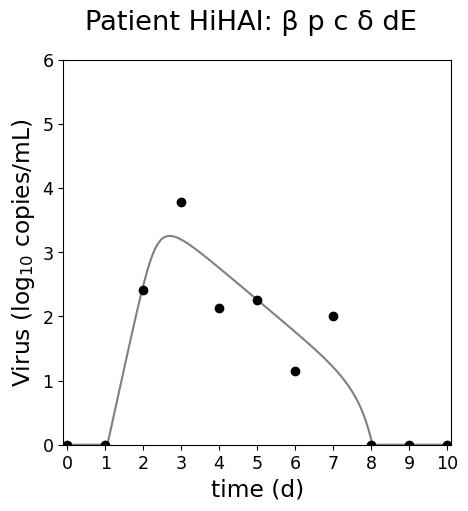

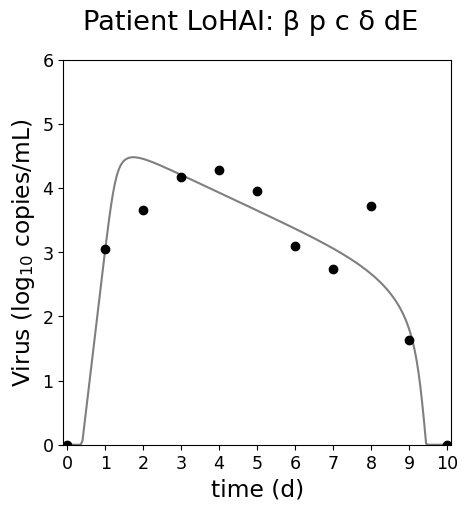

In [3]:
# Cohort 3  High/Low baseline HAI Titer
targets = ['HiHAI', 'LoHAI']

df = read_excel("../data/Cohort3.xlsx")
df_Cohort3 = df[['VOLUNTEER', 'DAY', 'V', 'S']]

patient_color_names = [
'deeppink',
'mediumpurple',]
color_mapping = {id_: color for id_, color in zip(targets, patient_color_names)}

subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,6]},
    #{'title': 'Symptoms', 'data_key': 'S', 'sol_key': None, 'ylims': [0,7]}, 
]

n_Z = 13 # Linear chain stage number
t_span = (0, 10)

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
] + [{'label': f'Z{i}', 'initial_value': 0.0, 'sse': False} for i in range(1, n_Z + 1)]

parameters = Parameters(
    E0=Parameter(name='E0', val=125751, bounds=(2.1E4, 1.7E5), method='fixed', space='log10'),
    M0=Parameter(name='M0', val=7497, bounds=(2E3, 3E4), method='fixed', space='log10'),
    MP0=Parameter(name='MP0', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, bounds=(1E7, 4E7), method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, bounds=(1, 1E3), method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=0.00077, bounds=(1E-6, 1E-2), method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, bounds=(1.0, 10.0), method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.31552, bounds=(0.01, 10.0), method='fit', space='normal'), 
    c=Parameter(name='c', val=246.8, bounds=(10.0, 500), method='fit', space='log10'), 
    delta=Parameter(name='delta', val=2, bounds=(0.2, 10), method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.18, bounds=(1E-1, 5.0), method='fixed', space='log10'), 
    a=Parameter(name='a', val=2, bounds=(2.0, 5), method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.17, bounds=(0.1, 5.0), method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=.27, bounds=(0.01, 1.0), method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.00469, bounds=(1E-3, 1.0), method='fixed', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.26, bounds=(0.1, 1.0), method='fixed', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

patients = Patients(ids=targets, df=df_Cohort3, t_span=t_span, parameters=parameters, states=states)
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=50, verbose=True, path='Cohort3', buff=True, vectorized=False)
    plot(results, subplot_configuration, t_span, figsize=(5,5))

In [2]:
# Rahil Setup - Primary Infection
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders

df = read_excel("../data/Rahil2020_Table8.xlsx")
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]

patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Effectors', 'data_key': ['CD8TE','CD8TM'], 'sol_key': [4,5], 'ylims': [6.5,10.5]}, 
]

n_Z = 13 # Linear chain stage number
t_span = (0, 8)

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': True},
] + [{'label': f'Z{i}', 'initial_value': 0.0, 'sse': False} for i in range(1, n_Z + 1)]


103 Differential Evolution with 25 generations.
[-4.41426979  1.81703372  1.84666702  0.78754415  1.76623539  6.31419435
 -0.22096682 -2.56638554  2.83108095  0.94478813  0.56003138]
103 polish
Results saved to ../sql/Rescalefinal.db.
Parameter beta: 3.8645825367214875e-05
Parameter p: 1.765690163633934
Parameter c: 63.21049416200666
Parameter delta: 0.6842042494235763
Parameter xi: 45.946707858553005
Parameter a: 6.2684387370564565
Parameter d_E: 0.4163699867203527
Parameter delta_E: 0.004021562666095604
Parameter K_delta_E: 668.2639529683617
Parameter zeta: 6.382488791342434
Parameter tau_memory: 0.5652032271031953


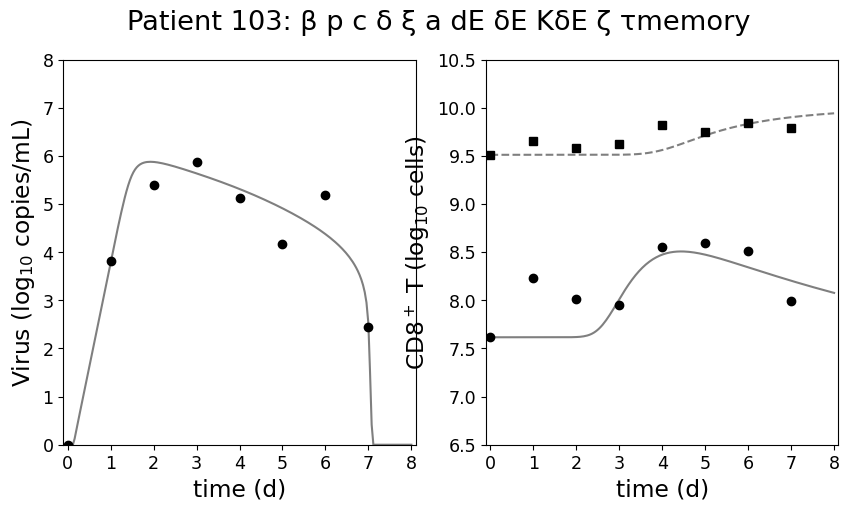

In [ ]:
# Cohort 1, fit with p
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, bounds=(2.1E4, 1.7E5), method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, bounds=(2E3, 3E4), method='file', space='log10'),
    MP0=Parameter(name='MP0', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, method='fixed'),
    I10=Parameter(name='I10', val=75, method='fixed'), 
    beta=Parameter(name='beta', val=0.000737509048473427, bounds=(1E-7, 1E-3), method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, method='fixed'), 
    p=Parameter(name='p', val=4.0, bounds=(0.1, 10.0), method='fit', space='normal'), 
    c=Parameter(name='c', val=1, bounds=(10.0, 500), method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, bounds=(0.05, 5), method='fit', space='normal'),
    xi=Parameter(name='xi', val=1.0, bounds=(0.4, 10.0), method='fit', space='log10'), 
    a=Parameter(name='a', val=5, bounds=(3.0, 10), method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.3, bounds=(0.05, 2.0), method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=2.0, bounds=(0.1, 10.0), method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, bounds=(1E-4, 0.1), method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.5, bounds=(0.25, 1.0), method='fit', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='../parameters/Primary.xlsx')
for target in [103]:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=False, path='Rahil_p', buff=True, vectorized=False)
    plot(results, subplot_configuration, t_span, figsize=(10,5))


In [ ]:

# Cohort 1, fit with p to Population
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, bounds=(2.1E4, 1.7E5), method='fit', space='log10'),
    M0=Parameter(name='M0', val=1E4, bounds=(2E3, 3E4), method='fit', space='log10'),
    MP0=Parameter(name='MP0', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, method='fixed'),
    I10=Parameter(name='I10', val=75, method='fixed'), 
    beta=Parameter(name='beta', val=0.000737509048473427, bounds=(1E-7, 1E-3), method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, method='fixed'), 
    p=Parameter(name='p', val=4.0, bounds=(0.1, 10.0), method='fit', space='normal'), 
    c=Parameter(name='c', val=1, bounds=(10.0, 500), method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, bounds=(0.05, 5), method='fit', space='normal'),
    xi=Parameter(name='xi', val=1.0, bounds=(0.4, 10.0), method='fit', space='log10'), 
    a=Parameter(name='a', val=5, bounds=(3.0, 10), method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.3, bounds=(0.05, 2.0), method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=2.0, bounds=(0.1, 10.0), method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, bounds=(1E-4, 0.1), method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.5, bounds=(0.25, 1.0), method='fit', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='../parameters/Primary.xlsx')
for target in ['Population']:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=50, verbose=True, path='Rahil_p_new', buff=True, vectorized=False)
    plot(results, subplot_configuration, t_span, figsize=(10,5))

103 Dual Annealing with 25 iterations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_16820\2077638231.py:483: RuntimeWarning: overflow encountered in scalar power
  self.parameters._parameters[name].val = 10**x[i]


103 polish


C:\Users\jorda\AppData\Local\Temp\ipykernel_16820\2077638231.py:716: OptimizeWarning: Unknown solver options: xatol, fatol
  result = minimize(


Results saved to sql/Rahil_Dose.db.
Parameter T0: 24137087.369348373
Parameter beta: 5.32569942239346e-05
Parameter c: 131.5609044520072
Parameter delta: 0.5660292231310561
Parameter xi: 0.6176229814504448
Parameter a: 4.286897097828173
Parameter d_E: 1.3017848201387698
Parameter delta_E: 1.0347625415005006
Parameter K_delta_E: 100.84356868478451
Parameter zeta: 0.021247653662879683
Parameter tau_memory: 0.25


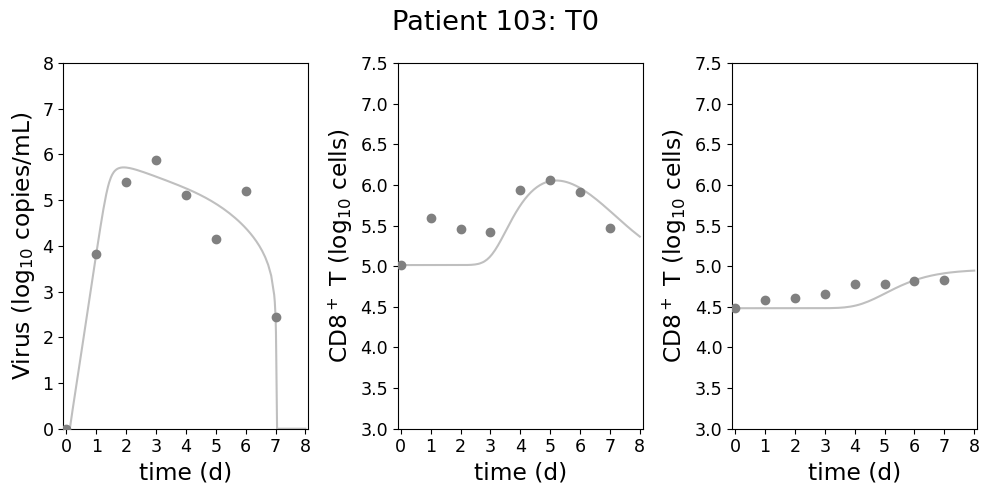

107 Dual Annealing with 25 iterations.
107 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 10000000.253101347
Parameter beta: 3.79081698691923e-06
Parameter c: 10.000000040101423
Parameter delta: 0.9087969185252335
Parameter xi: 0.5216707510915165
Parameter a: 9.999804073286532
Parameter d_E: 0.28799707946140246
Parameter delta_E: 1.0182068610288704
Parameter K_delta_E: 6685.568058335107
Parameter zeta: 0.016706356477516063
Parameter tau_memory: 0.5999862689892823


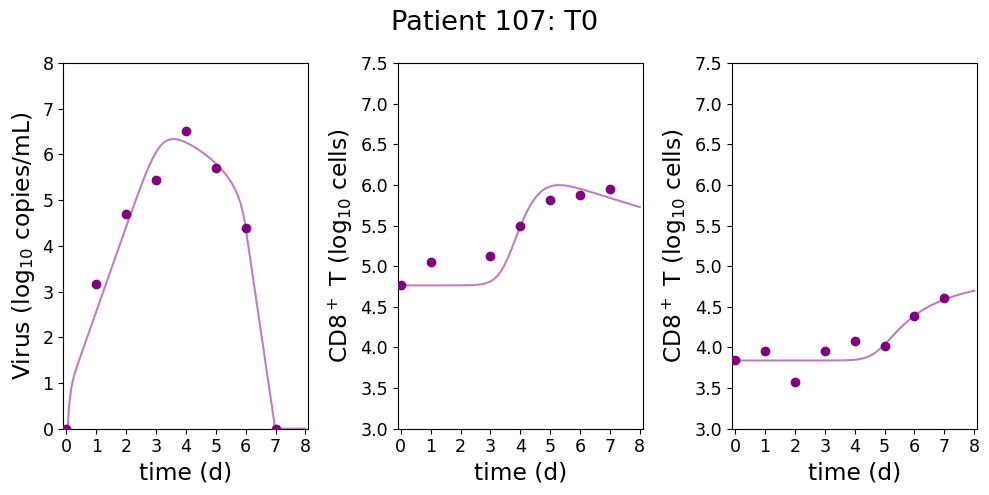

110 Dual Annealing with 25 iterations.
110 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 10000102.035784423
Parameter beta: 8.320207490933395e-05
Parameter c: 85.10177415530802
Parameter delta: 0.9486751741990512
Parameter xi: 0.9055890059474261
Parameter a: 6.538763333187387
Parameter d_E: 1.1973162124040007
Parameter delta_E: 0.34155392418127445
Parameter K_delta_E: 120.52446497305942
Parameter zeta: 0.007369589517570765
Parameter tau_memory: 0.250005828470238


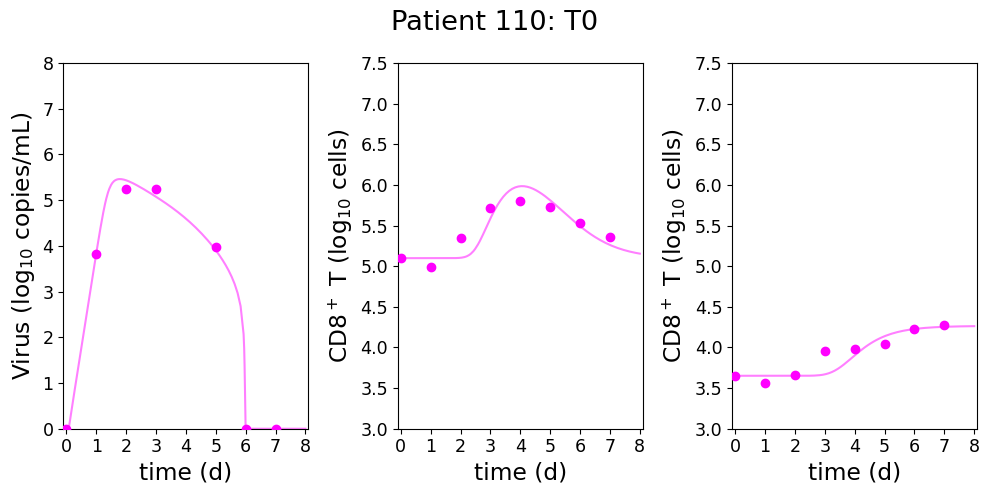

111 Dual Annealing with 25 iterations.
111 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 16790363.57645433
Parameter beta: 0.00012346302366471988
Parameter c: 216.04271733960502
Parameter delta: 0.05
Parameter xi: 3.3997159072476726
Parameter a: 6.5998481065812165
Parameter d_E: 0.05000015684279854
Parameter delta_E: 0.30167442244809417
Parameter K_delta_E: 12426.251865308592
Parameter zeta: 0.001325455241348017
Parameter tau_memory: 0.7433802367600539


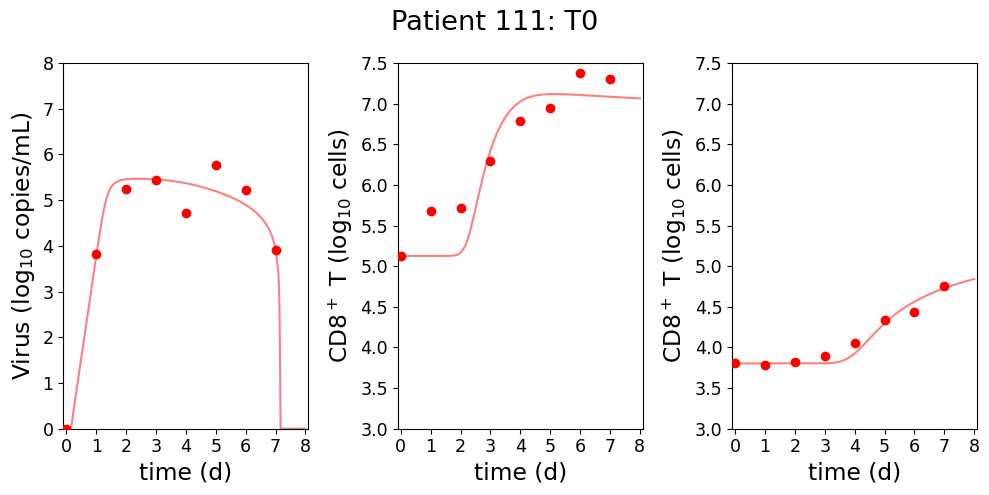

112 Dual Annealing with 25 iterations.
112 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 10007460.512207435
Parameter beta: 6.865291085985783e-06
Parameter c: 11.187066564711287
Parameter delta: 0.7353182611760449
Parameter xi: 0.4000355273089937
Parameter a: 7.642601057712893
Parameter d_E: 1.013235562694673
Parameter delta_E: 9.376342784233008
Parameter K_delta_E: 220.21987074003943
Parameter zeta: 0.01999619039255129
Parameter tau_memory: 0.9494620395123206


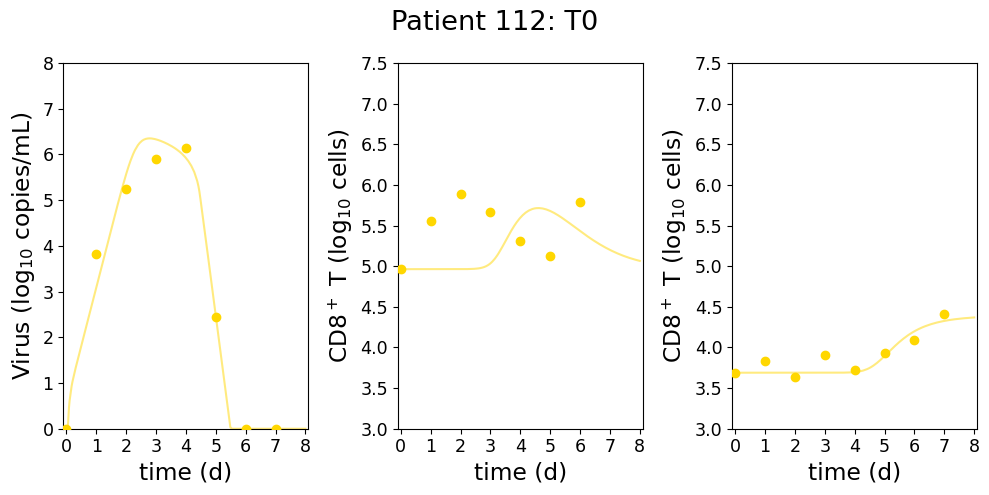

204 Dual Annealing with 25 iterations.
204 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 14926812.997637657
Parameter beta: 0.000391729879080407
Parameter c: 448.0970096570377
Parameter delta: 2.081763894925065
Parameter xi: 1.0133914362423337
Parameter a: 4.086289150211927
Parameter d_E: 0.0711320836747226
Parameter delta_E: 0.10000671827077351
Parameter K_delta_E: 2874.739045830403
Parameter zeta: 0.0005510566314607499
Parameter tau_memory: 0.2500008503018939


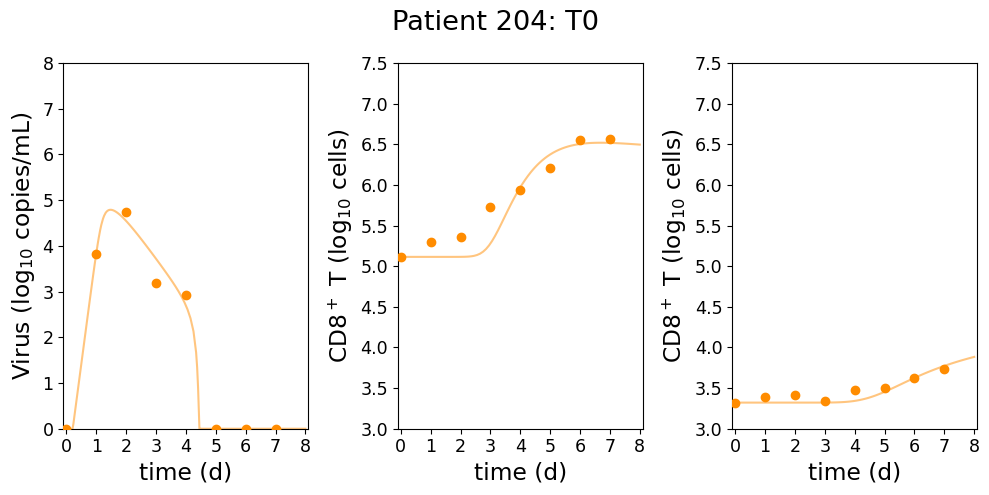

207 Dual Annealing with 25 iterations.
207 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 21008459.093157656
Parameter beta: 2.055969037399072e-05
Parameter c: 46.46847470847772
Parameter delta: 1.013535761348319
Parameter xi: 4.140608680003871
Parameter a: 8.258168878607128
Parameter d_E: 0.3422789037932476
Parameter delta_E: 0.1
Parameter K_delta_E: 100000.0
Parameter zeta: 0.0011688525304795708
Parameter tau_memory: 0.2649448382717273


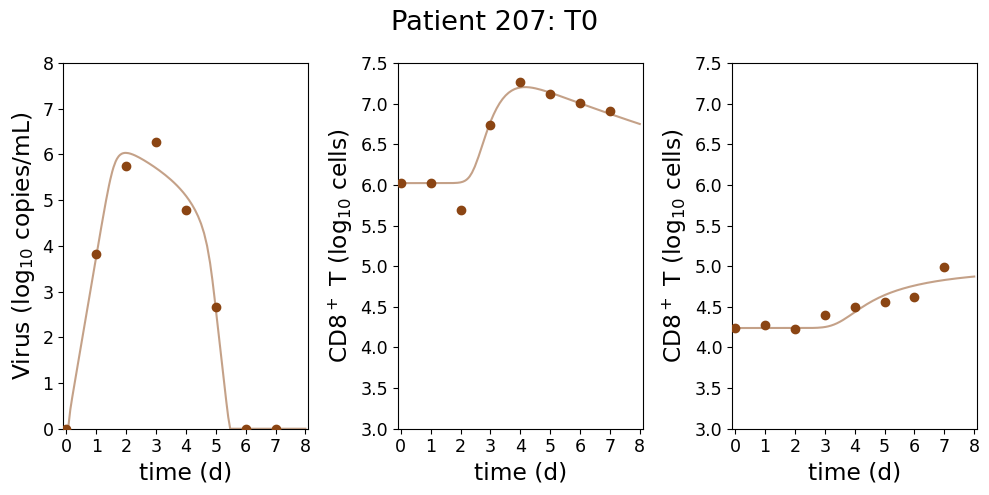

302 Dual Annealing with 25 iterations.
302 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 11660692.829882268
Parameter beta: 1.4715912783763044e-05
Parameter c: 11.846140652520782
Parameter delta: 0.5945641295712514
Parameter xi: 3.6739931411320783
Parameter a: 7.742111990459049
Parameter d_E: 0.6445189875877997
Parameter delta_E: 0.23178604259398888
Parameter K_delta_E: 345.4146404917212
Parameter zeta: 0.001700266788398452
Parameter tau_memory: 0.2525087014854341


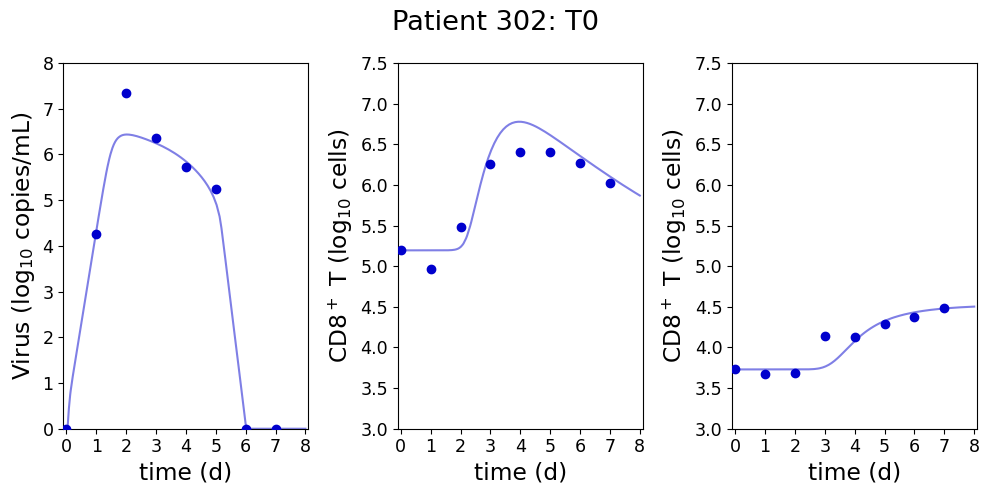

307 Dual Annealing with 25 iterations.
307 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 31035251.962580465
Parameter beta: 7.240388453962996e-06
Parameter c: 11.748042860726894
Parameter delta: 0.19453855804483786
Parameter xi: 1.6976555212814624
Parameter a: 5.206566373169485
Parameter d_E: 0.7877530011982927
Parameter delta_E: 3.0106669463518467
Parameter K_delta_E: 137.00788518217092
Parameter zeta: 0.0015391374145364357
Parameter tau_memory: 0.26886091836417453


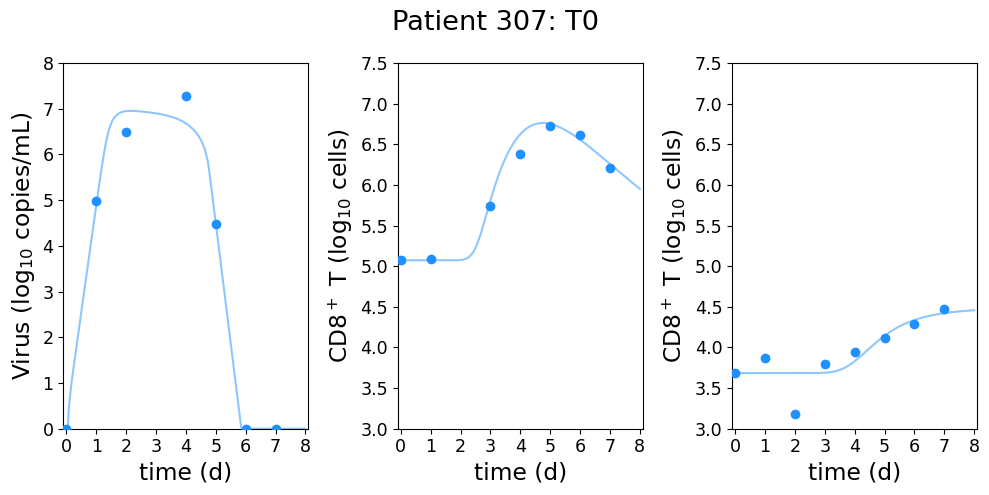

308 Dual Annealing with 25 iterations.
308 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 24357206.921887673
Parameter beta: 5.366702906549005e-05
Parameter c: 153.94209811676984
Parameter delta: 0.3498593971890354
Parameter xi: 0.6615493239068521
Parameter a: 4.337885337875208
Parameter d_E: 1.2005013045317108
Parameter delta_E: 2.240120443196936
Parameter K_delta_E: 2604.360184919224
Parameter zeta: 0.01892332862139557
Parameter tau_memory: 0.2512953780915994


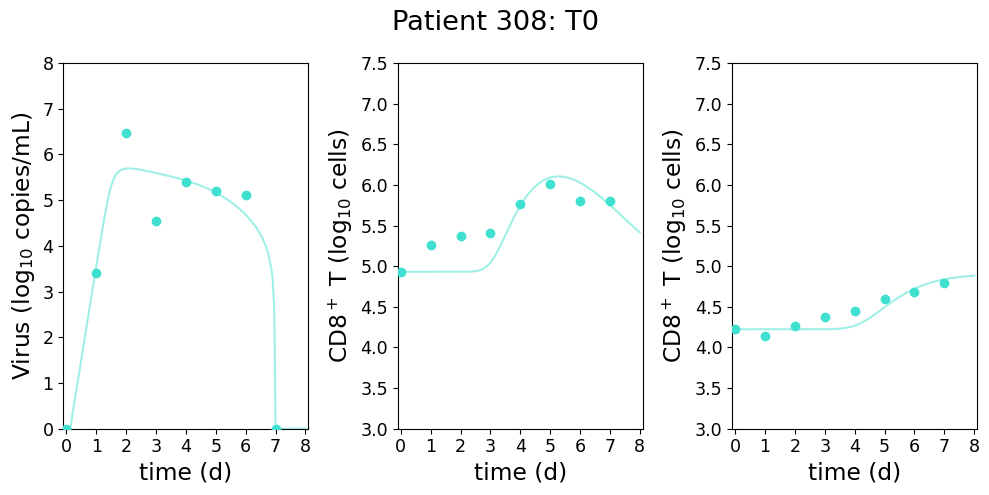

311 Dual Annealing with 25 iterations.
311 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 13036615.406426294
Parameter beta: 0.00013443487472858813
Parameter c: 149.31494658103873
Parameter delta: 2.5772586749505657
Parameter xi: 0.4000509914292972
Parameter a: 9.999806578480905
Parameter d_E: 0.7131235248857283
Parameter delta_E: 2.225754815744995
Parameter K_delta_E: 105.63576674626879
Parameter zeta: 0.006863576227065864
Parameter tau_memory: 0.6921176711008847


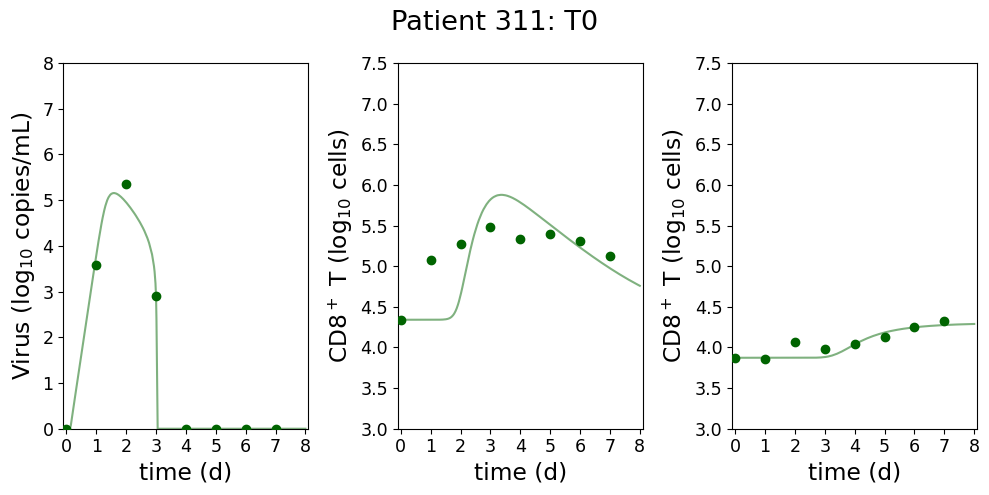

312 Dual Annealing with 25 iterations.
312 polish
Results saved to sql/Rahil_Dose.db.
Parameter T0: 79999994.48550075
Parameter beta: 7.784471573072684e-06
Parameter c: 313.53507456827487
Parameter delta: 0.343926842802177
Parameter xi: 0.44101471662210695
Parameter a: 9.97695061583579
Parameter d_E: 0.6924223124870387
Parameter delta_E: 9.999999999351774
Parameter K_delta_E: 26842.691008250153
Parameter zeta: 0.0014477948411284714
Parameter tau_memory: 0.25186493537667853


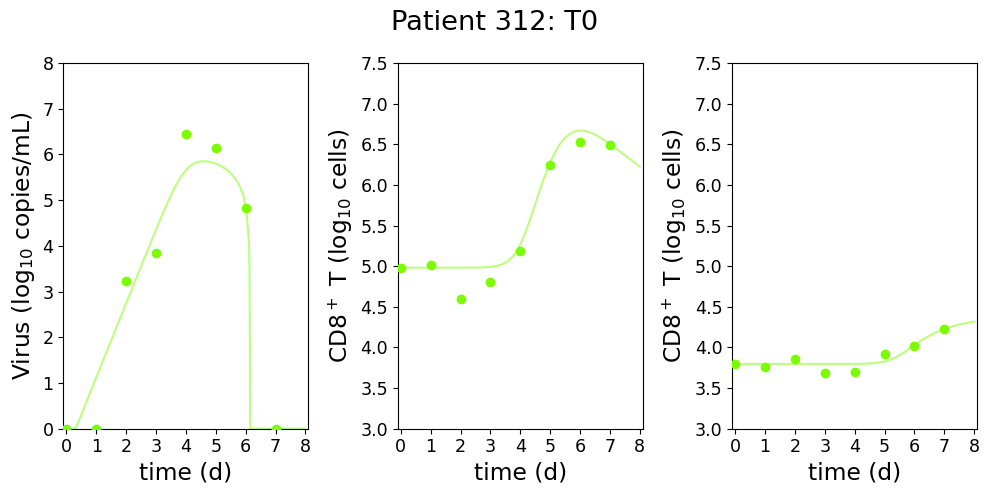

In [10]:
# Cohort 1, fit to Individuals (dose)
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, bounds=(2.1E4, 1.7E5), method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, bounds=(2E3, 3E4), method='file', space='log10'),
    ME=Parameter(name='ME', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, bounds=(1E7, 8E7), method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, method='fixed'), 
    beta=Parameter(name='beta', val=0.000737509048473427, bounds=(1E-7, 1E-3), method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, method='fixed'), 
    p=Parameter(name='p', val=4.0, method='fixed'), 
    c=Parameter(name='c', val=1, bounds=(10.0, 500), method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, bounds=(0.05, 5), method='fit', space='normal'),
    xi=Parameter(name='xi', val=1.0, bounds=(0.4, 10.0), method='fit', space='log10'), 
    a=Parameter(name='a', val=5, bounds=(3.0, 10), method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.3, bounds=(0.05, 2.0), method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=2.0, bounds=(0.1, 10.0), method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, bounds=(1E-4, 0.1), method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.5, bounds=(0.25, 1.0), method='fit', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='../parameters/Primary.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=50, verbose=True, path='Rahil_T0_new', buff=True, vectorized=False)
    plot(results, subplot_configuration, t_span, figsize=(10,5))
# Cohort 1, fit to Population (dose)
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, bounds=(2.1E4, 1.7E5), method='fit', space='log10'),
    M0=Parameter(name='M0', val=1E4, bounds=(2E3, 3E4), method='fit', space='log10'),
    ME=Parameter(name='ME', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, bounds=(1E7, 8E7), method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, method='fixed'), 
    beta=Parameter(name='beta', val=0.000737509048473427, bounds=(1E-7, 1E-3), method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, method='fixed'), 
    p=Parameter(name='p', val=4.0, method='fixed'), 
    c=Parameter(name='c', val=1, bounds=(10.0, 500), method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, bounds=(0.05, 5), method='fit', space='normal'),
    xi=Parameter(name='xi', val=1.0, bounds=(0.4, 10.0), method='fit', space='log10'), 
    a=Parameter(name='a', val=5, bounds=(3.0, 10), method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.3, bounds=(0.05, 2.0), method='fit', space='log10'),
    delta_E=Parameter(name='delta_E', val=2.0, bounds=(0.1, 10.0), method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, bounds=(1E-4, 0.1), method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.5, bounds=(0.25, 1.0), method='fit', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ['Population']:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=50, verbose=True, path='Rahil_T0_new', buff=True, vectorized=False)
    plot(results, subplot_configuration, t_span, figsize=(10,5))

No parameters to optimize
ID: 103 solved in: 0.006000995635986328, cost: 2.077759249466921
No parameters to optimize
ID: 103 solved in: 0.0019996166229248047, cost: 151.62110937148898


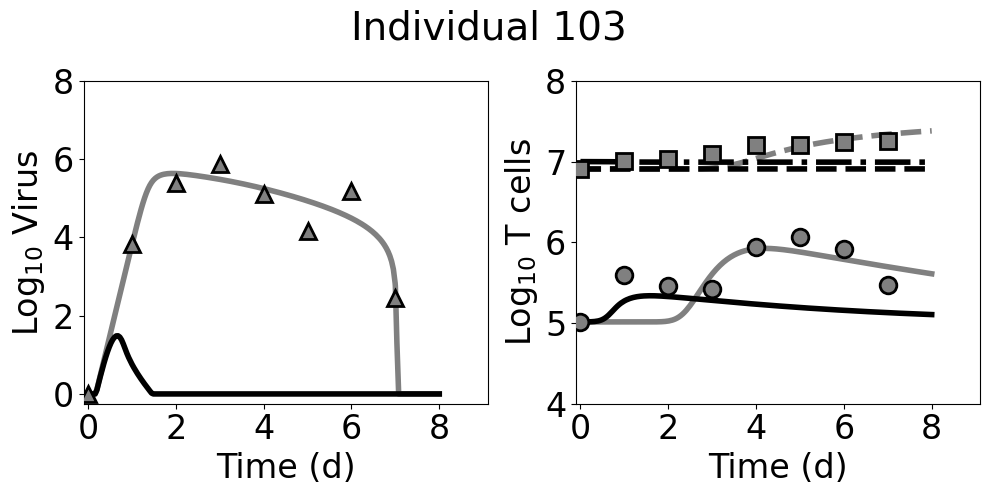

No parameters to optimize
ID: 107 solved in: 0.0024988651275634766, cost: 1.5474187444480227
No parameters to optimize
ID: 107 solved in: 0.0019979476928710938, cost: 71.78147999381213


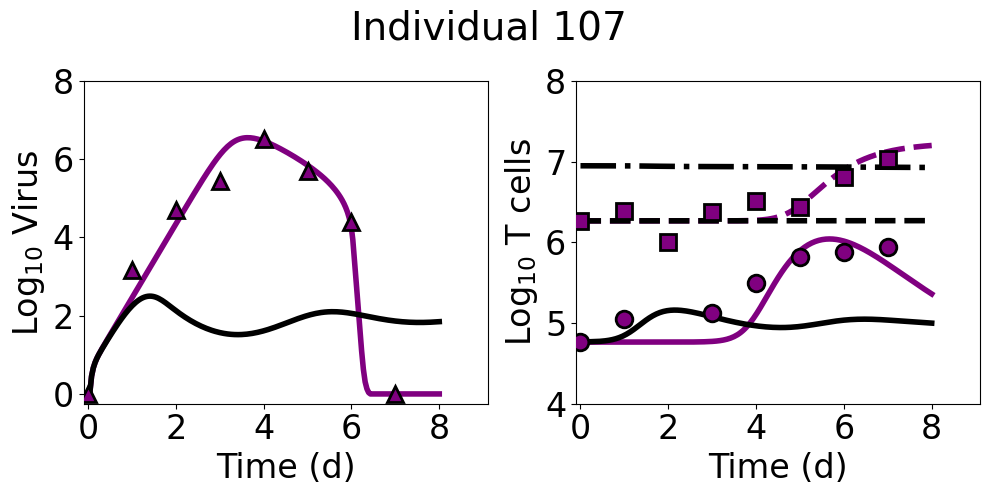

No parameters to optimize
ID: 110 solved in: 0.0020003318786621094, cost: 0.0853372118465775
No parameters to optimize
ID: 110 solved in: 0.002499818801879883, cost: 16.913761106269032


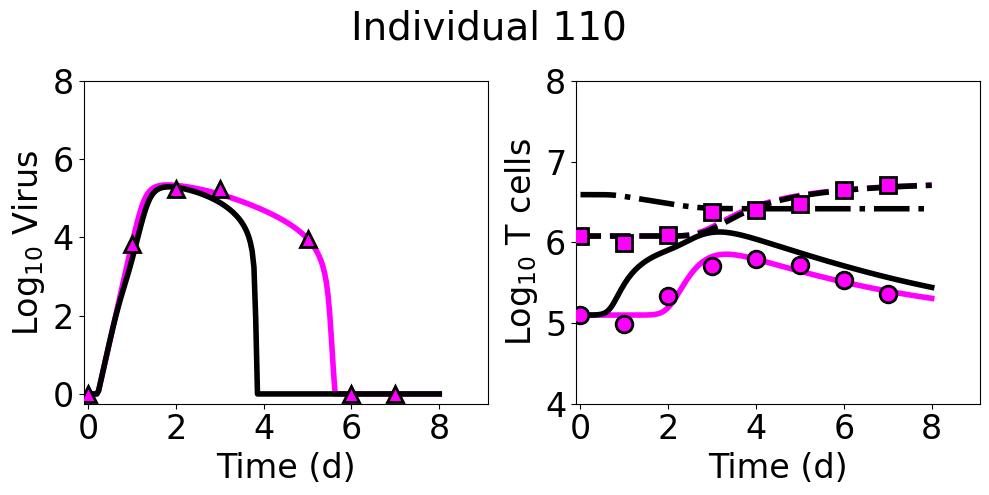

No parameters to optimize
ID: 111 solved in: 0.0019986629486083984, cost: 16.98482070127319
No parameters to optimize
ID: 111 solved in: 0.001497507095336914, cost: 176.98509365494013


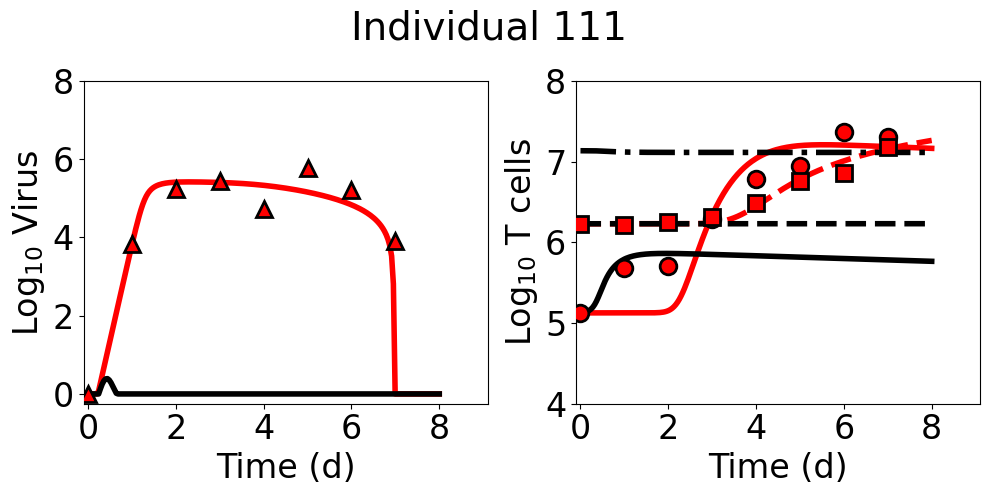

No parameters to optimize
ID: 112 solved in: 0.0025014877319335938, cost: 5.539356451841545
No parameters to optimize
ID: 112 solved in: 0.002001047134399414, cost: 1.1931943627286392


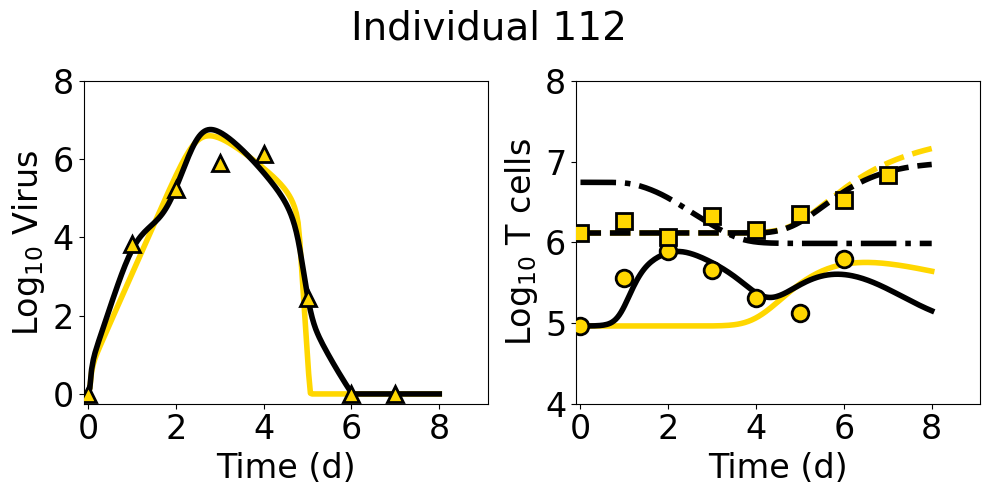

No parameters to optimize
ID: 204 solved in: 0.0025010108947753906, cost: 0.9710033682388682
No parameters to optimize
ID: 204 solved in: 0.001997709274291992, cost: 1.7794268299630351


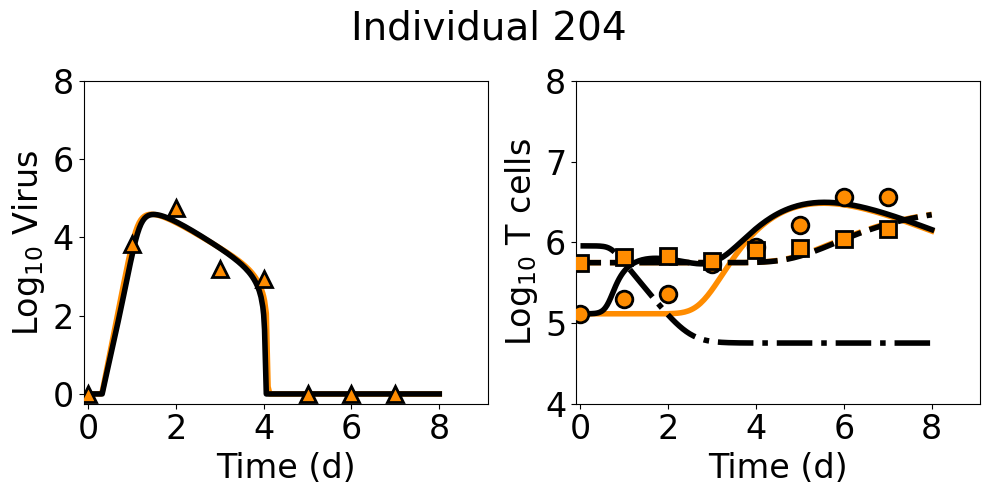

No parameters to optimize
ID: 207 solved in: 0.0025000572204589844, cost: 0.604108239502438
No parameters to optimize
ID: 207 solved in: 0.0025000572204589844, cost: 120.33685950284824


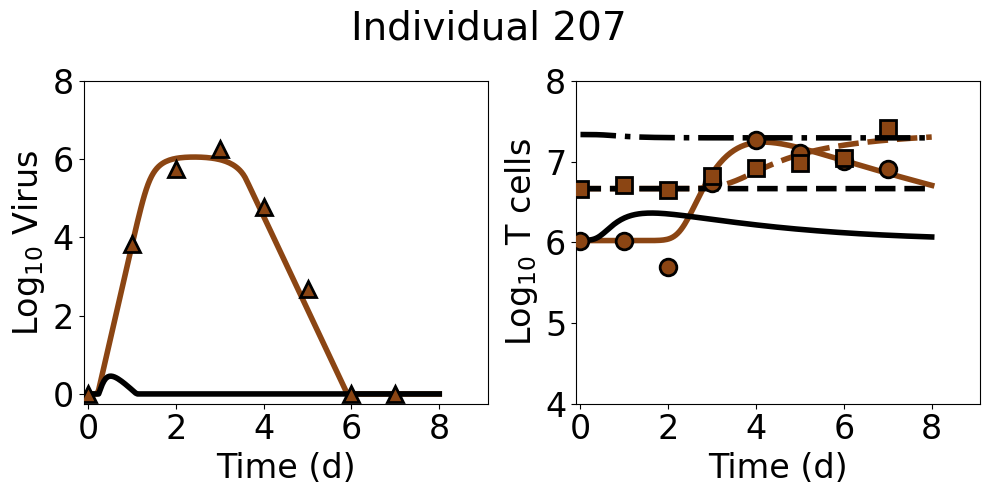

No parameters to optimize
ID: 302 solved in: 0.0025022029876708984, cost: 0.39564710571028566
No parameters to optimize
ID: 302 solved in: 0.002499818801879883, cost: 2.8728374699685273


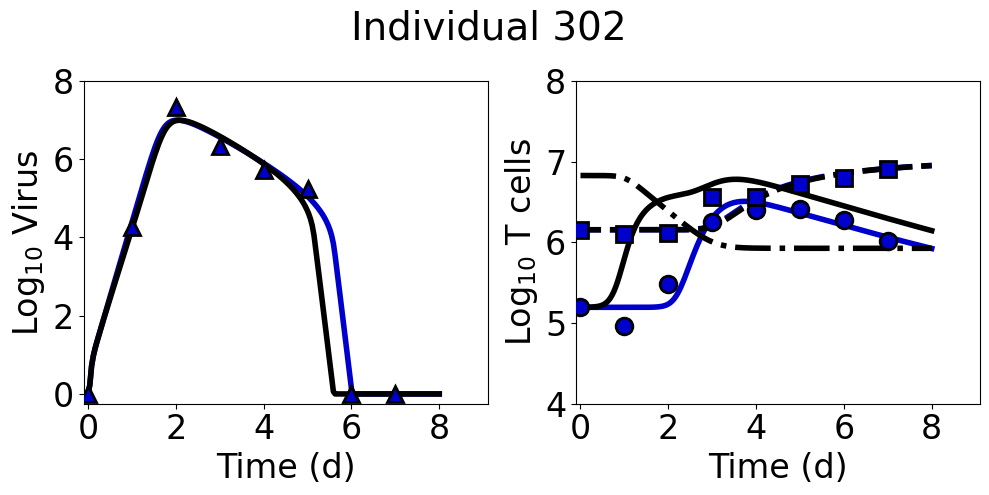

No parameters to optimize
ID: 307 solved in: 0.0019989013671875, cost: 3.3434404753239786
No parameters to optimize
ID: 307 solved in: 0.0019979476928710938, cost: 145.3314568565157


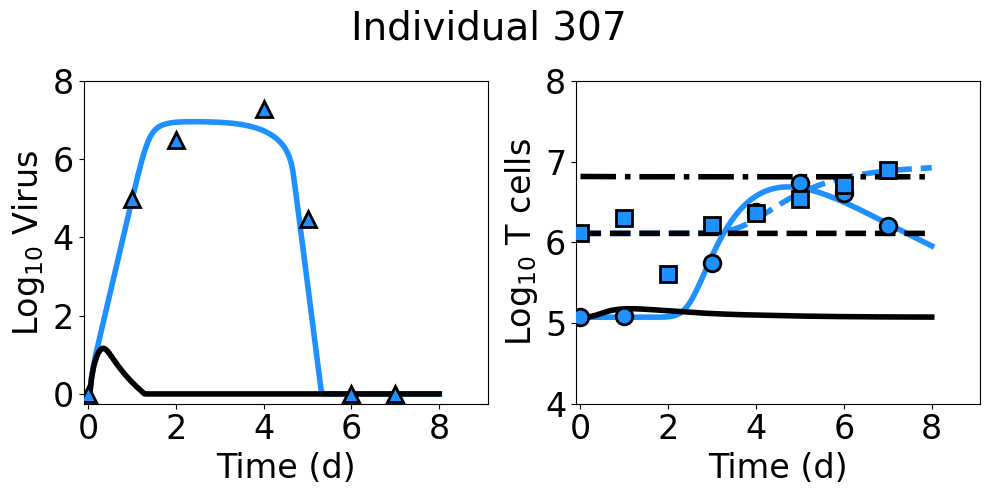

No parameters to optimize
ID: 308 solved in: 0.002501249313354492, cost: 2.2011160988002
No parameters to optimize
ID: 308 solved in: 0.002002239227294922, cost: 152.7483634693179


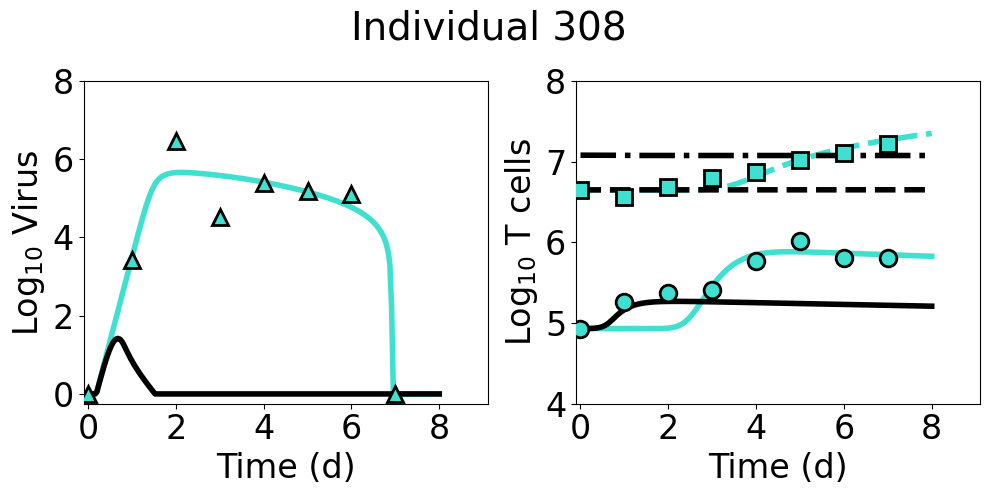

No parameters to optimize
ID: 311 solved in: 0.002497434616088867, cost: 5.03056485277194
No parameters to optimize
ID: 311 solved in: 0.0019986629486083984, cost: 0.15149832102767957


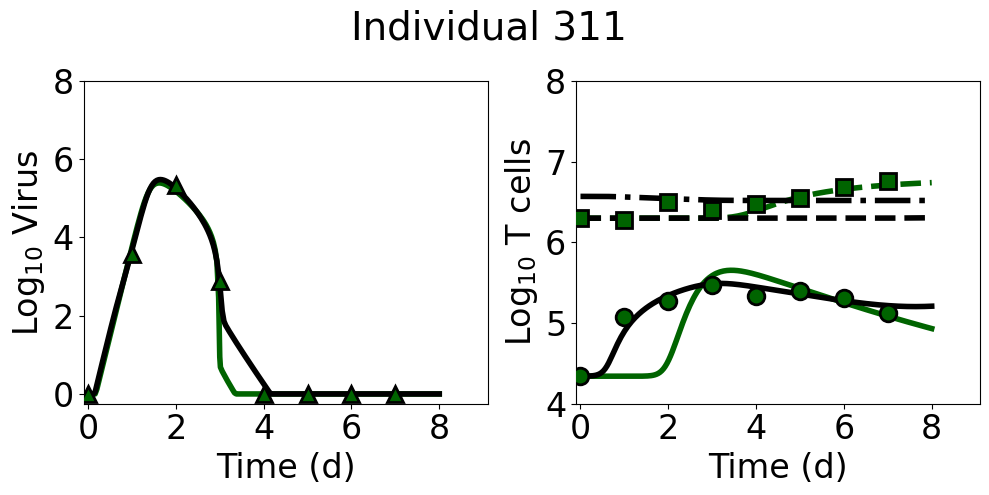

No parameters to optimize
ID: 312 solved in: 0.0020008087158203125, cost: 3.8004435262780922
No parameters to optimize
ID: 312 solved in: 0.0020017623901367188, cost: 112.7264368436806


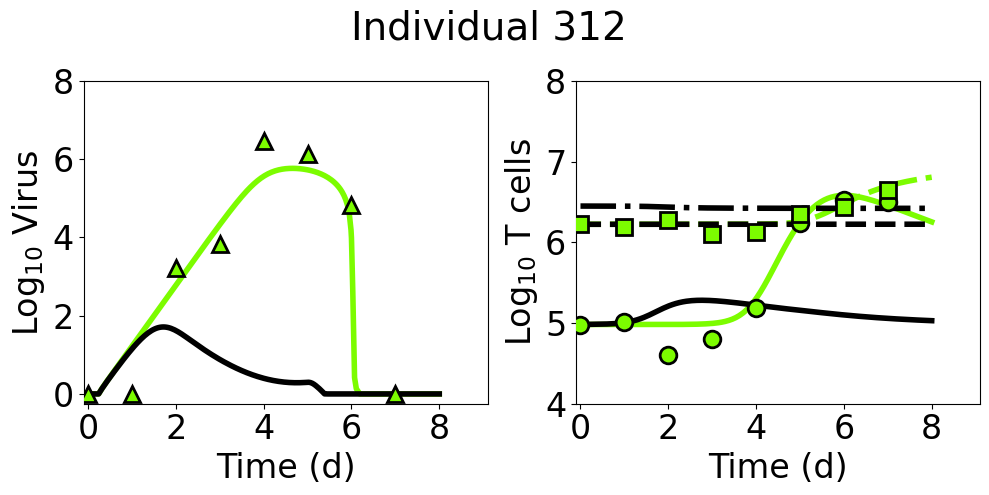

In [28]:
# Rahil Setup - Rechallenge Forecast
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [-0.25,8]},
    {'title': 'T Cells', 'data_key': ['CD8TE','CD8TM',None], 'sol_key': [4, 5, 6], 'ylims': [4,8]}, 
]

shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
n_Z = 13 # Linear chain stage number
t_span = (0, 8)

df = read_excel("../data/Cohort1.xlsx")
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]

patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
] + [{'label': f'Z{i}', 'initial_value': 0.0, 'sse': False} for i in range(1, n_Z + 1)]

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, bounds=(2.1E4, 1.7E5), method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, bounds=(2E3, 3E4), method='file', space='log10'),
    MP0=Parameter(name='MP0', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, method='fixed'),
    I10=Parameter(name='I10', val=75, method='fixed'), 
    beta=Parameter(name='beta', val=0.000737509048473427, bounds=(1E-7, 1E-3), method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, method='fixed'), 
    p=Parameter(name='p', val=4.0, bounds=(0.1, 10.0), method='file', space='normal'), 
    c=Parameter(name='c', val=1, bounds=(10.0, 500), method='file', space='log10'), 
    delta=Parameter(name='delta', val=3, bounds=(0.05, 5), method='file', space='normal'),
    xi=Parameter(name='xi', val=1.0, bounds=(0.4, 10.0), method='file', space='log10'), 
    a=Parameter(name='a', val=5, bounds=(3.0, 10), method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=0.3, bounds=(0.05, 2.0), method='file', space='log10'),
    delta_E=Parameter(name='delta_E', val=2.0, bounds=(0.1, 10.0), method='file', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, bounds=(1E-4, 0.1), method='file', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.5, bounds=(0.25, 1.0), method='file', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

states_rechallenge = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TMP', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TEP', 'initial_value': 0.0, 'sse': False},
] + [{'label': f'Z{i}', 'initial_value': 0.0, 'sse': False} for i in range(1, n_Z + 1)]

parameters_rechallenge = Parameters(
    E0=Parameter(name='E0', val=0, bounds=(2.1E4, 1.7E5), method='file', space='log10'),
    M0=Parameter(name='M0', val=0, bounds=(2E3, 3E4), method='file', space='log10'),
    MP0=Parameter(name='MP0', val=0, bounds=(2E4, 3E5), method='file', space='log10'),
    T0=Parameter(name='T0', val=4E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=7.84E-5, bounds=(1E-7, 1E-3), method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, method='fixed'), 
    p=Parameter(name='p', val=2.977, bounds=(0.1, 10.0), method='file', space='normal'), 
    c=Parameter(name='c', val=160, bounds=(10.0, 500), method='file', space='log10'), 
    delta=Parameter(name='delta', val=3.29, bounds=(0.05, 5), method='file', space='normal'),
    xi=Parameter(name='xi', val=0.04298, bounds=(0.4, 10.0), method='file', space='log10'), 
    a=Parameter(name='a', val=7.3921, bounds=(3.0, 10), method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=1.5, bounds=(0.5, 5.0), method='file', space='log10'),
    delta_E=Parameter(name='delta_E', val=0.1, bounds=(0.1, 10.0), method='file', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=9771, bounds=(1E2, 1E5), method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.014, bounds=(1E-4, 0.1), method='file', space='log10'),
    eta=Parameter(name='eta', val=200, bounds=(1E-3, 1), method='file', space='log10'), 
    K_I1=Parameter(name='K_I1', val=45678, bounds=(1E2, 1E6), method='file', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=1.01, bounds=(0.25, 1.0), method='file', space='normal'),
    damp=Parameter(name='damp', val=10, bounds=(1.0, 10), method='file')
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='../parameters/Primary.xlsx')
patients_rechallenge = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters_rechallenge, states=states_rechallenge, parameter_file='../parameters/Reinfection.xlsx', reinfection=True)

for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='PrimaryInfectionn')
    results_rechallenge = patients_rechallenge.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Reinfection_new', buff=True)
     
    plot_per_patient_both_sets(
        results=results,
        results_rechallenge=results_rechallenge,
        subplot_config=subplot_configuration,
        t_span=[0,9],
        figsize=(10,5),
        patient_color=color_mapping.get(target, 'black'),
        save=True
    )

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
1 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 14.005775650256822
differential_evolution step 2: f(x)= 12.06724635724694
differential_evolution step 3: f(x)= 12.06724635724694
differential_evolution step 4: f(x)= 12.06724635724694
differential_evolution step 5: f(x)= 12.06724635724694
differential_evolution step 6: f(x)= 12.06724635724694
differential_evolution step 7: f(x)= 12.06724635724694
differential_evolution step 8: f(x)= 12.06724635724694
differential_evolution step 9: f(x)= 12.06724635724694
differential_evolution step 10: f(x)= 12.06724635724694
differential_evolution step 11: f(x)= 12.06724635724694
differential_evolution step 12: f(x)= 11.992582405131689
differential_evolution step 13: f(x)= 11.992582405131689
differential_evolution step 14: f(x)= 11.992582405131689
differential_evolution step 15: f(x)= 11.538353922834663
differential_evolution s

C:\Users\jorda\AppData\Local\Temp\ipykernel_35576\658078334.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)


differential_evolution step 1: f(x)= 4.368111947004795
differential_evolution step 2: f(x)= 4.368111947004795
differential_evolution step 3: f(x)= 4.368111947004795
differential_evolution step 4: f(x)= 3.276213583617789
differential_evolution step 5: f(x)= 3.197053906811206
differential_evolution step 6: f(x)= 3.197053906811206
differential_evolution step 7: f(x)= 3.197053906811206
differential_evolution step 8: f(x)= 3.197053906811206
differential_evolution step 9: f(x)= 3.197053906811206
differential_evolution step 10: f(x)= 2.990199553187221
differential_evolution step 11: f(x)= 2.990199553187221
differential_evolution step 12: f(x)= 2.990199553187221
differential_evolution step 13: f(x)= 2.990199553187221
differential_evolution step 14: f(x)= 2.9782586175049994
differential_evolution step 15: f(x)= 2.9782586175049994
differential_evolution step 16: f(x)= 2.9782586175049994
differential_evolution step 17: f(x)= 2.9782586175049994
differential_evolution step 18: f(x)= 2.9782586175049

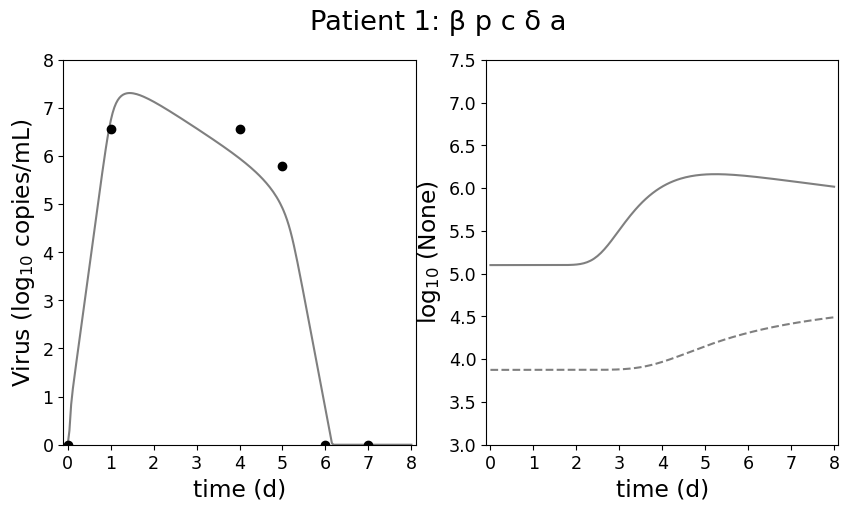

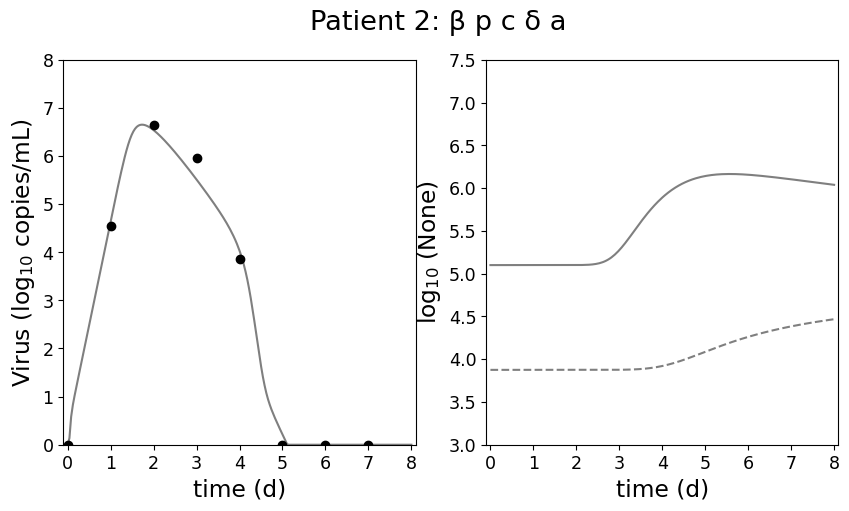

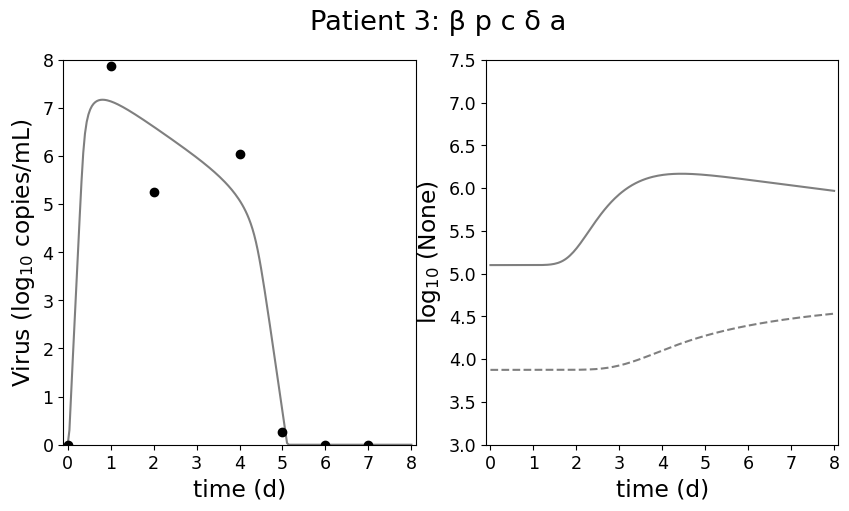

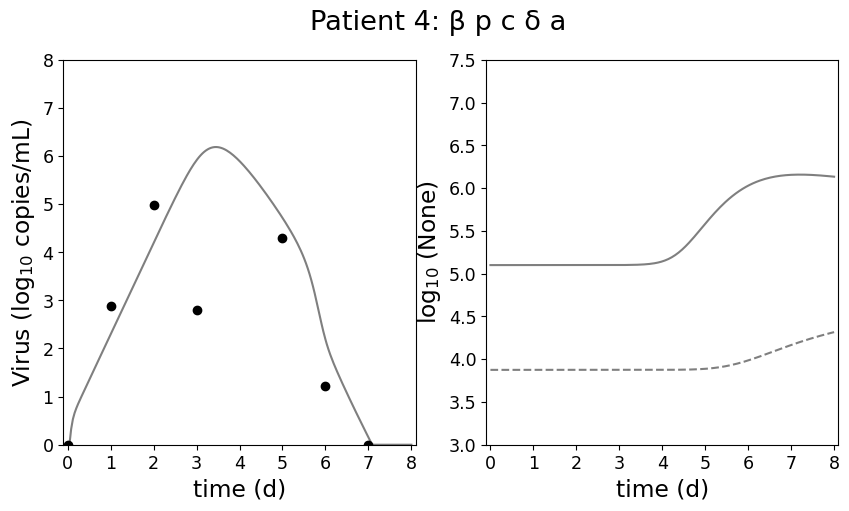

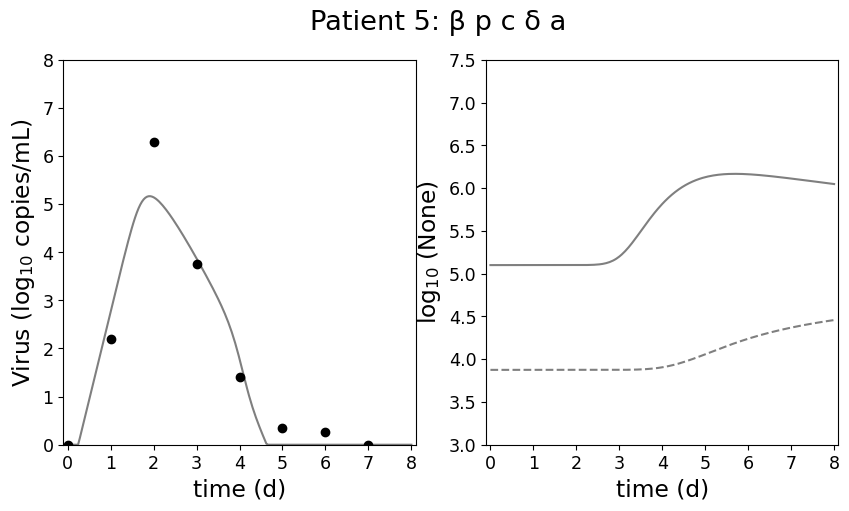

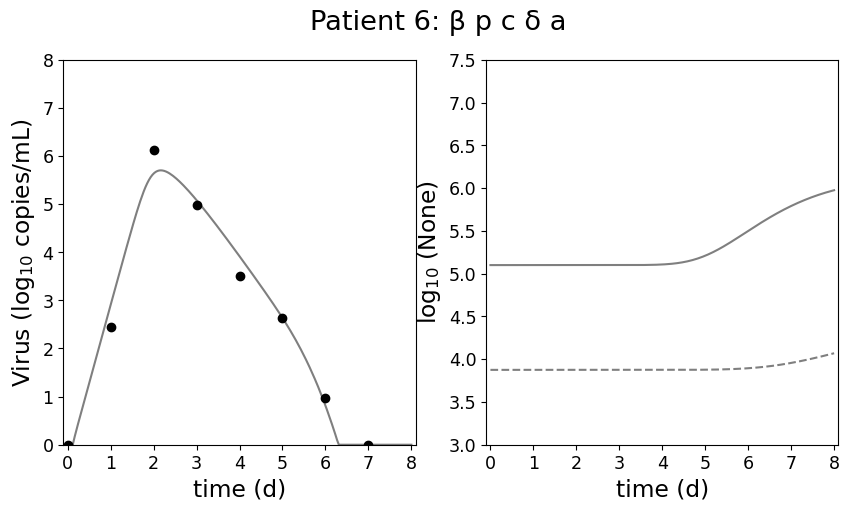

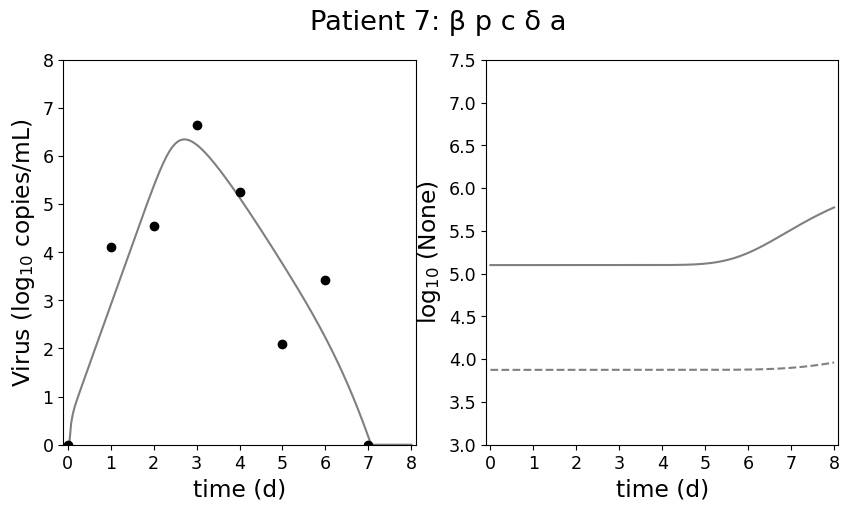

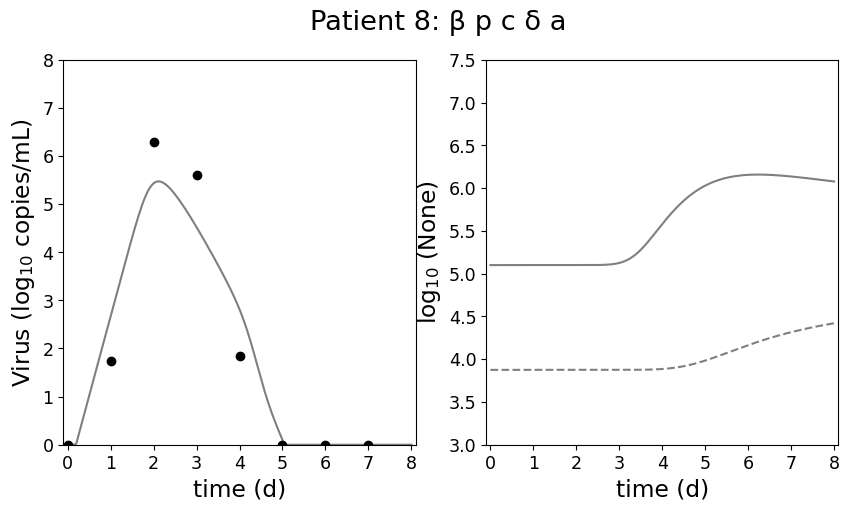

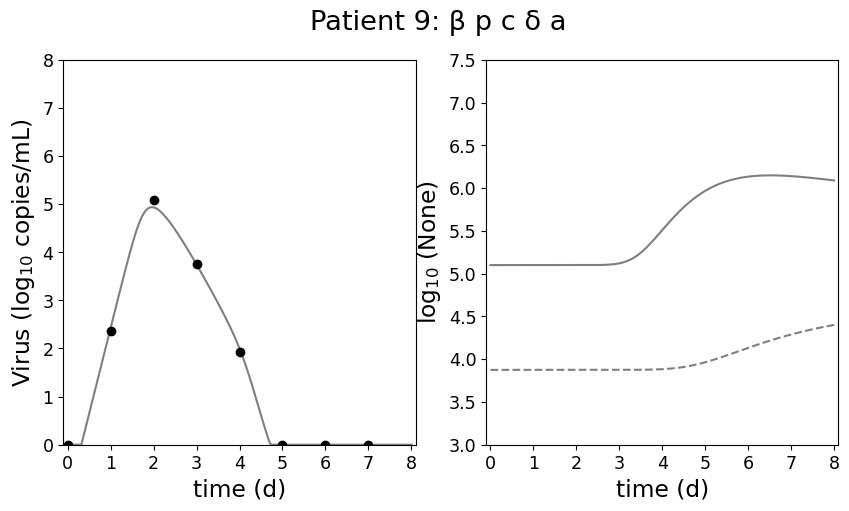

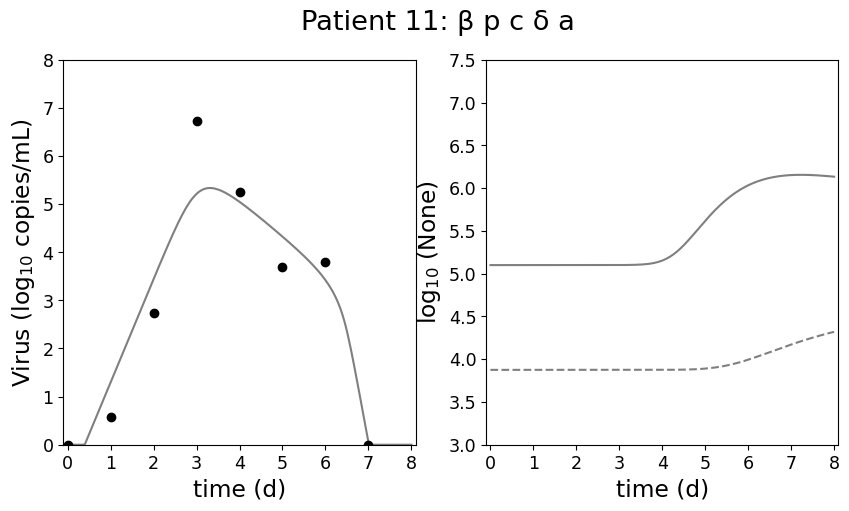

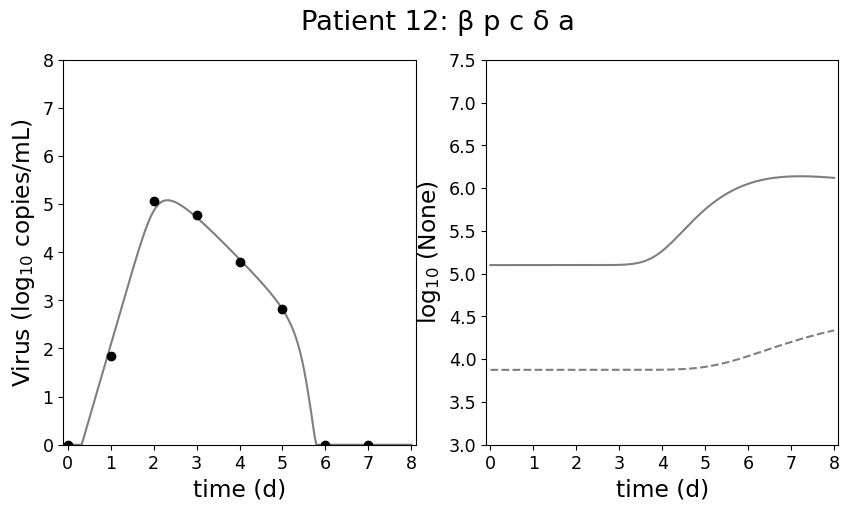

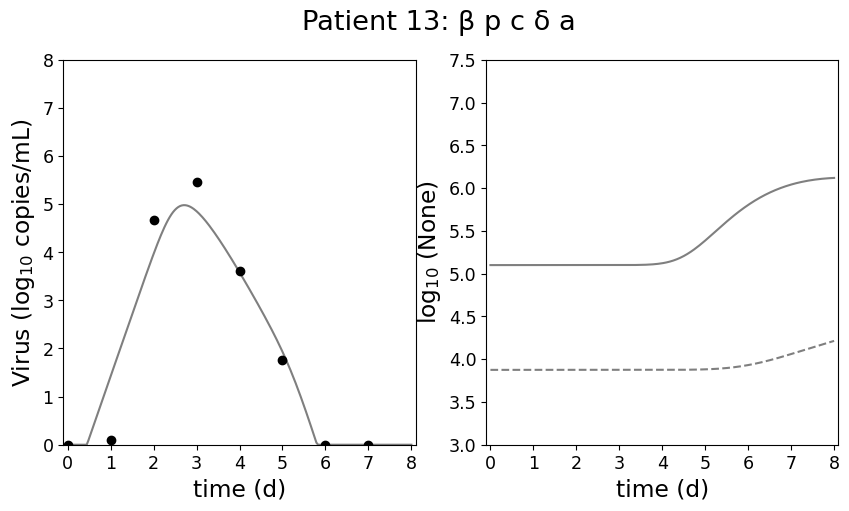

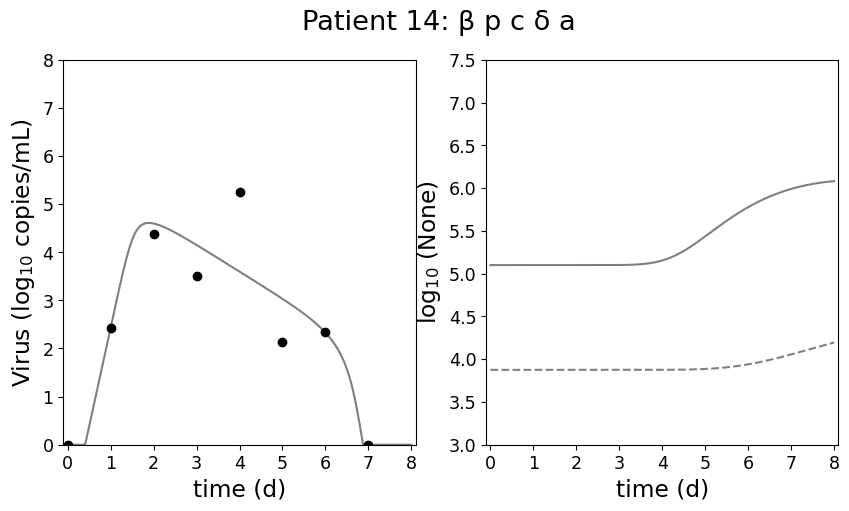

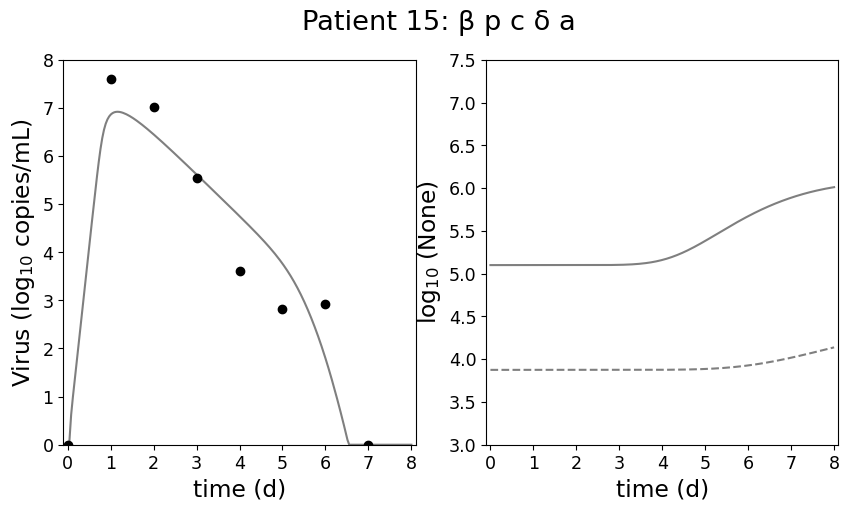

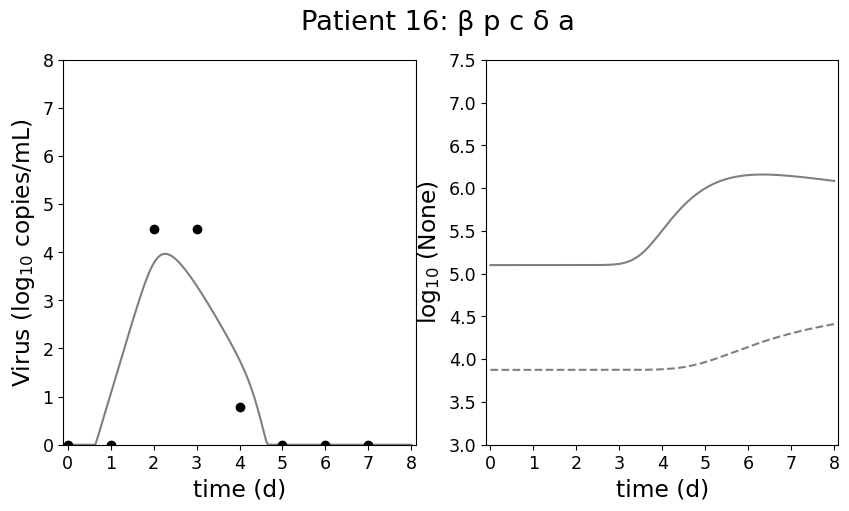

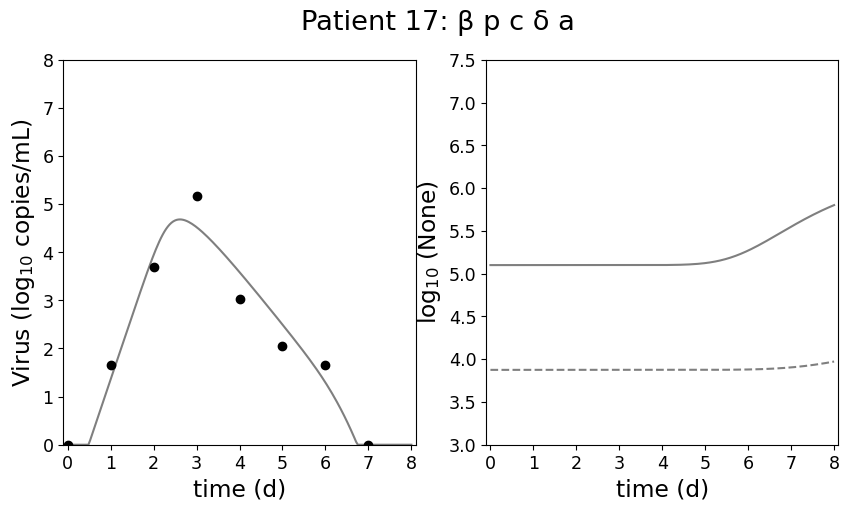

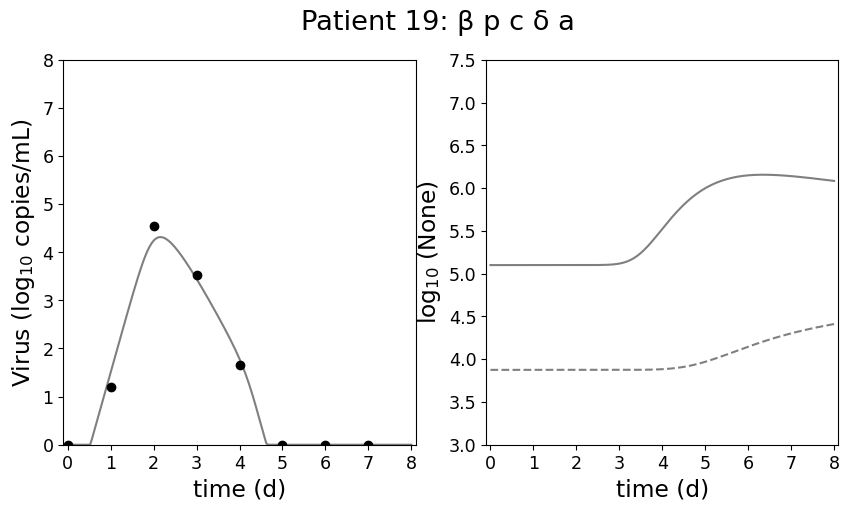

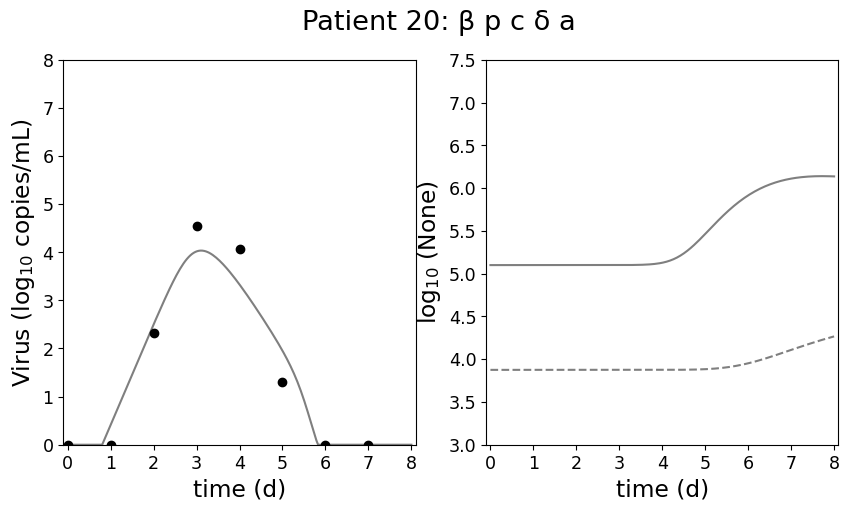

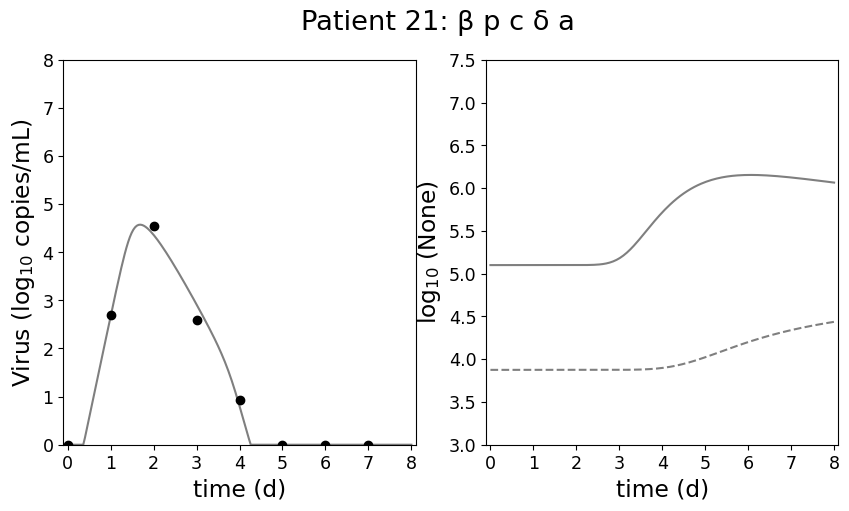

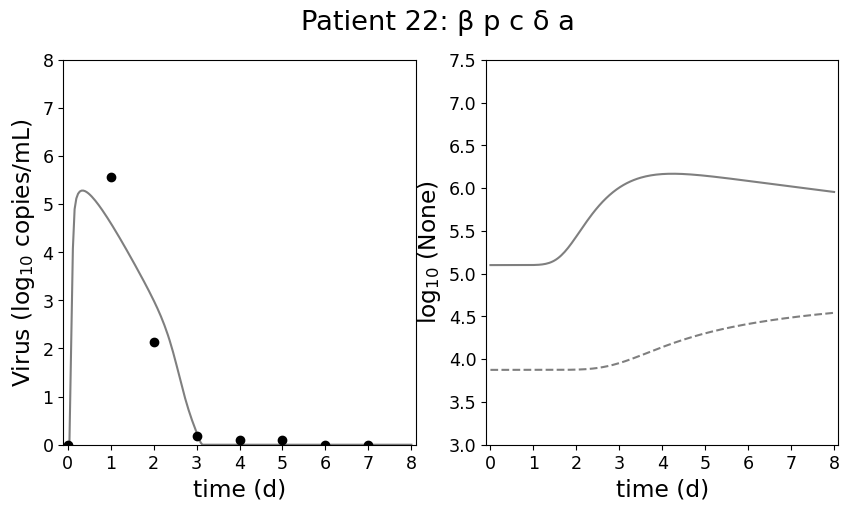

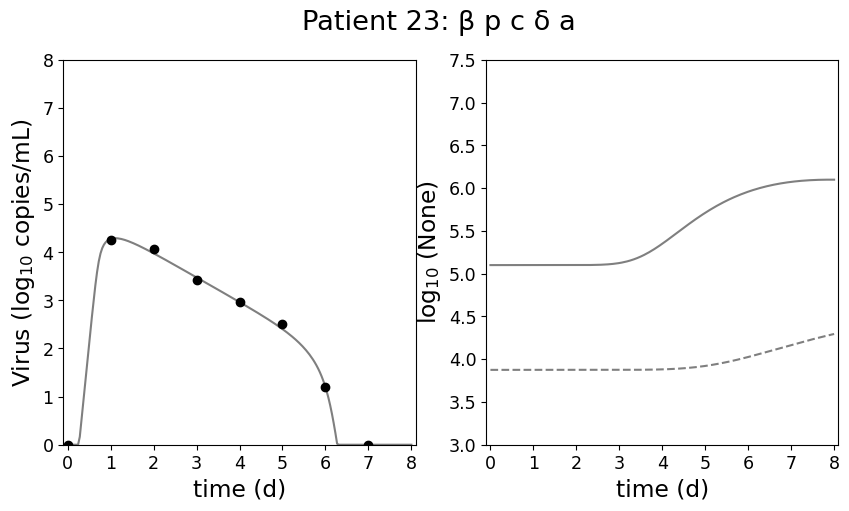

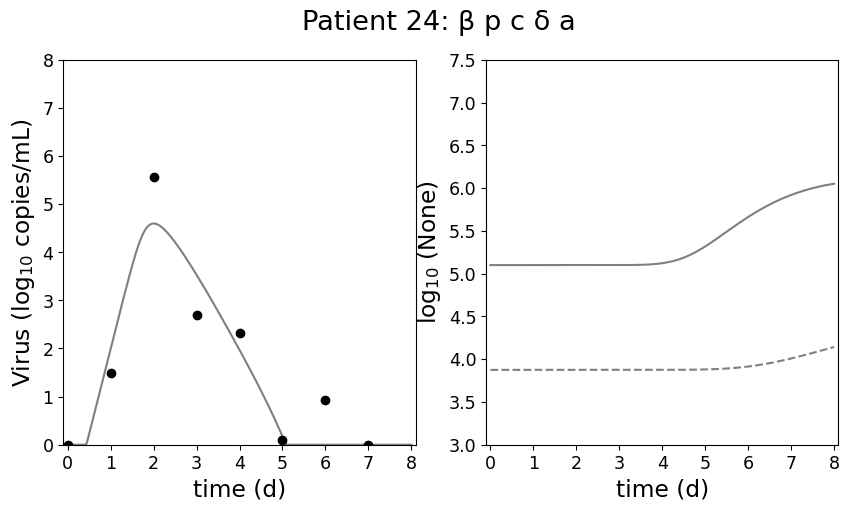

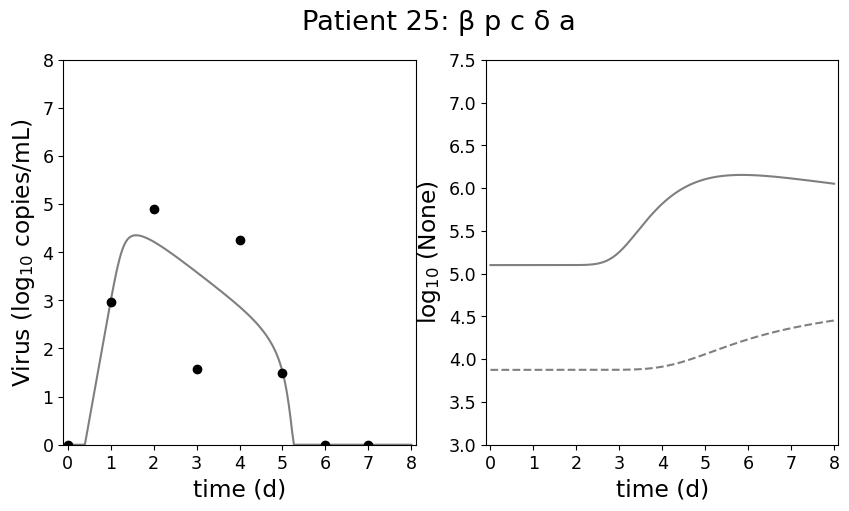

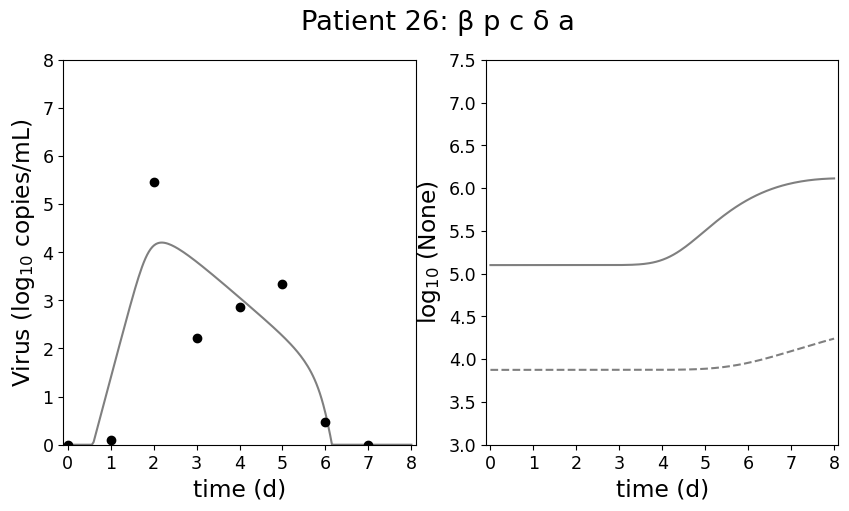

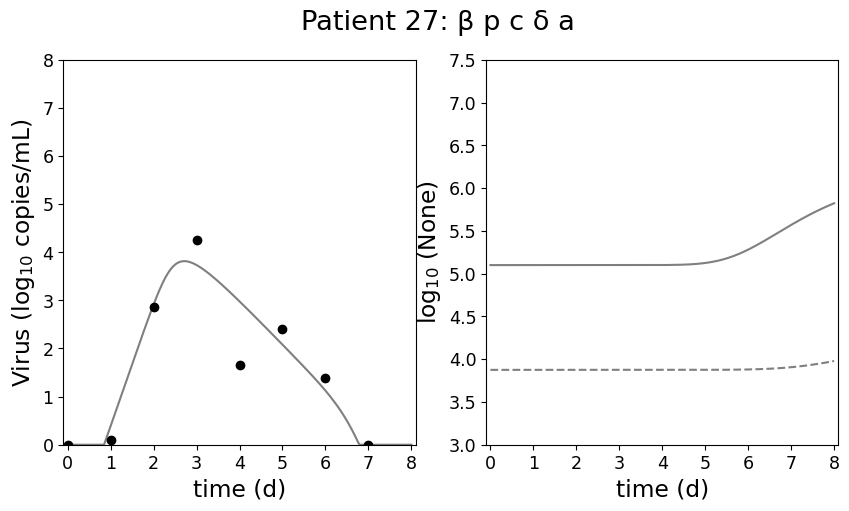

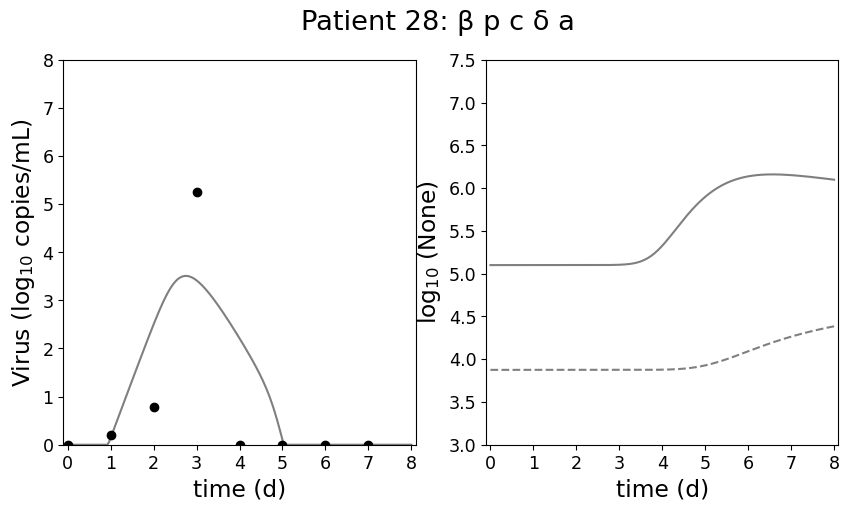

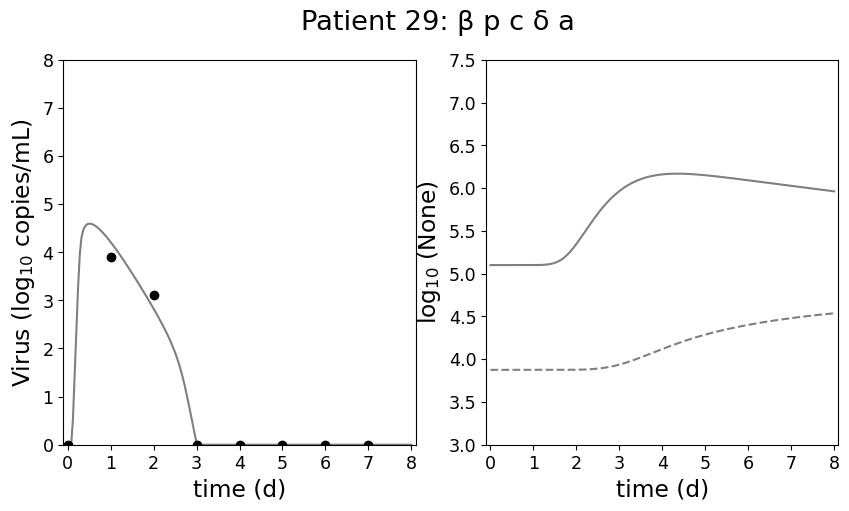

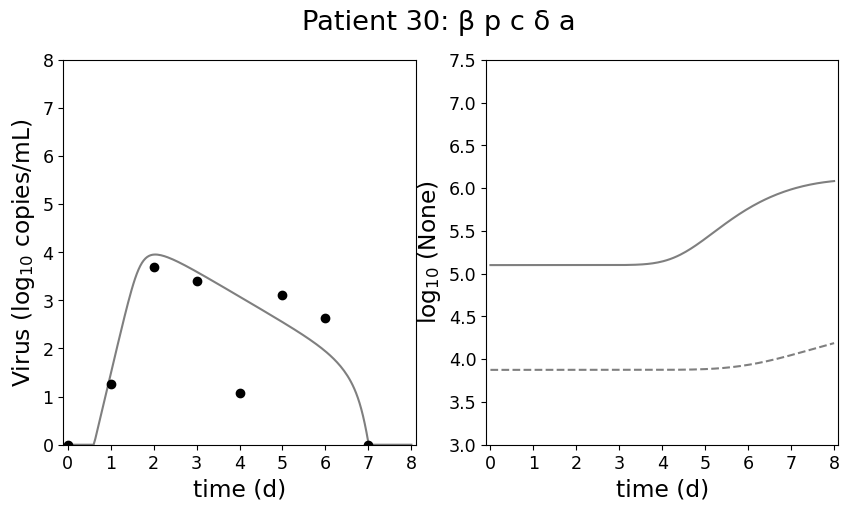

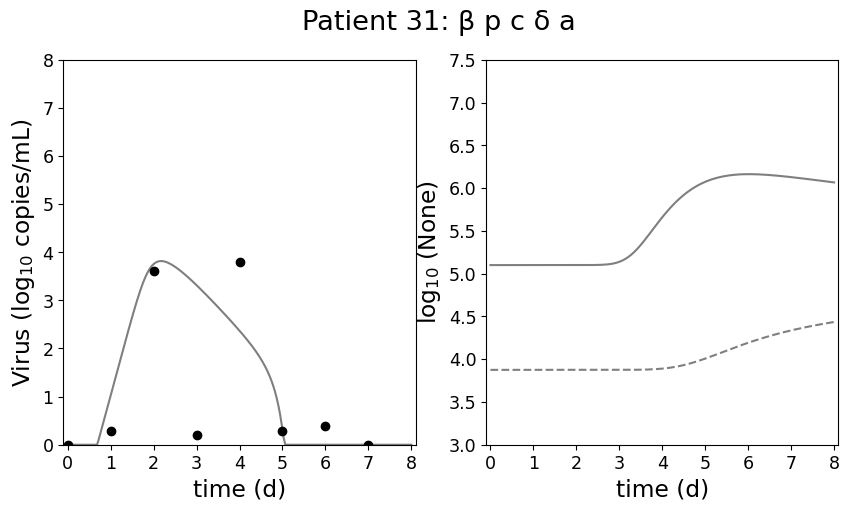

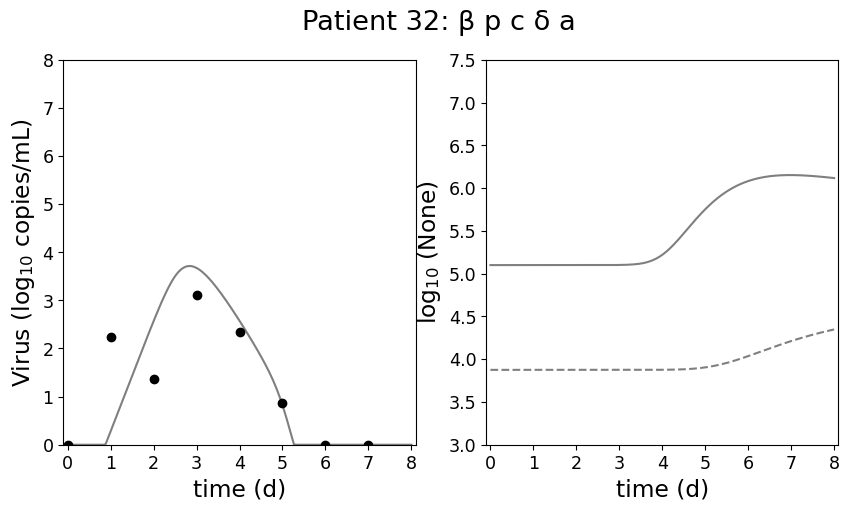

In [4]:
# Canini a
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': None, 'sol_key': [4, 5], 'ylims': [3,7.5]}, 
]

n_Z = 13
df = pd.read_excel("../data/Canini.xlsx")
df_Canini = df[['VOLUNTEER', 'DAY', 'V', 'RS', 'SS', 'TSS']]

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=125751, bounds=(2.1E4, 1.7E5), method='fixed', space='log10'),
    M0=Parameter(name='M0', val=7497, bounds=(2E3, 3E4), method='fixed', space='log10'),
    MP0=Parameter(name='MP0', val=0, bounds=(2E4, 3E5), method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, bounds=(1E7, 4E7), method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, bounds=(1, 1E3), method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=0.0007791133061046021, bounds=(1E-6, 1E-2), method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, bounds=(1.0, 10.0), method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.315521923958, bounds=(0.1, 10.0), method='fit', space='normal'), 
    c=Parameter(name='c', val=246.8, bounds=(10.0, 250), method='fit', space='log10'), 
    delta=Parameter(name='delta', val=2, bounds=(0.25, 5), method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.18, bounds=(1E-1, 5.0), method='fixed', space='log10'), 
    a=Parameter(name='a', val=2, bounds=(2.0, 5), method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.17, bounds=(0.3, 2.0), method='fixed', space='log10'),
    delta_E=Parameter(name='delta_E', val=.27, bounds=(0.01, 1.0), method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, bounds=(1E2, 1E5), method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.00469, bounds=(1E-3, 1.0), method='fixed', space='log10'),
    eta=Parameter(name='eta', val=0, bounds=(1, 100), method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, bounds=(1E2, 1E6), method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.26, bounds=(0.1, 1.0), method='fixed', space='normal'),
    damp=Parameter(name='damp', val=14, method='fixed'),
)

t_span = (0, 8)
shedders = [i for i in range(1, 33) if i not in {10, 18}]
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

patients = Patients(ids=ids, df=df_Canini, t_span=t_span, parameters=parameters, states=states)
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Canini_a', buff=True)
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), save=True)

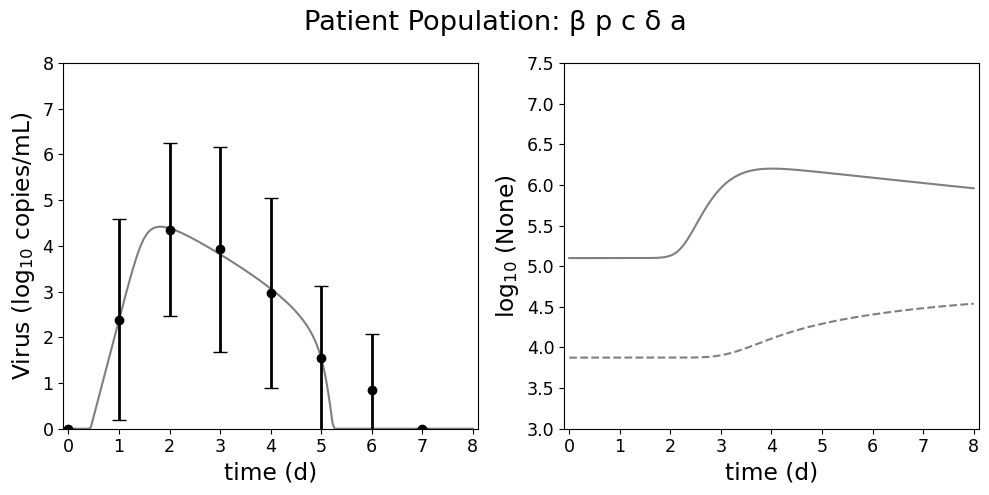

In [28]:
plot(results, subplot_configuration, t_span, figsize=(10,5))

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
1 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 20.996813389451084
differential_evolution step 2: f(x)= 20.996813389451084
differential_evolution step 3: f(x)= 20.996813389451084
differential_evolution step 4: f(x)= 20.34540028531039
differential_evolution step 5: f(x)= 20.34540028531039
differential_evolution step 6: f(x)= 20.34540028531039
differential_evolution step 7: f(x)= 20.34540028531039
differential_evolution step 8: f(x)= 20.34540028531039
differential_evolution step 9: f(x)= 20.34540028531039
differential_evolution step 10: f(x)= 19.936462012075886
differential_evolution step 11: f(x)= 19.936462012075886
differential_evolution step 12: f(x)= 19.936462012075886
differential_evolution step 13: f(x)= 19.936462012075886
differential_evolution step 14: f(x)= 19.936462012075886
differential_evolution step 15: f(x)= 19.819706812509942
differential_evoluti

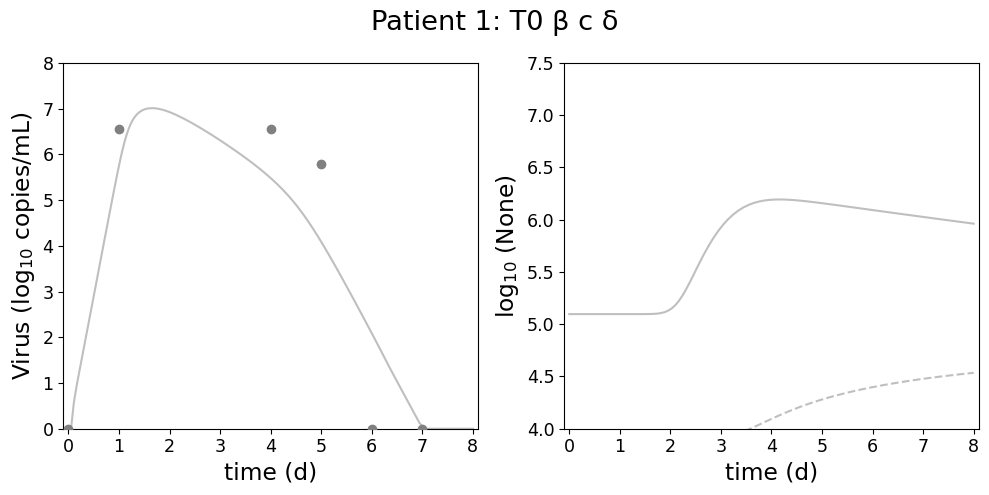

2 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.8510955146285497
differential_evolution step 2: f(x)= 1.7420653729022357
differential_evolution step 3: f(x)= 1.6388868906784373
differential_evolution step 4: f(x)= 1.6300142544094087
differential_evolution step 5: f(x)= 1.6300142544094087
differential_evolution step 6: f(x)= 1.5886228657132648
differential_evolution step 7: f(x)= 1.5886228657132648
differential_evolution step 8: f(x)= 1.5886228657132648
differential_evolution step 9: f(x)= 1.5886228657132648
differential_evolution step 10: f(x)= 1.5577667026826125
differential_evolution step 11: f(x)= 1.5577667026826125
differential_evolution step 12: f(x)= 1.5577667026826125
differential_evolution step 13: f(x)= 1.5577667026826125
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Parameter T0: 39816319.176653326
Parameter beta: 1.0769063850489587e-05
Parameter c: 13.369634689252244
Parameter delta: 3.069853577517769


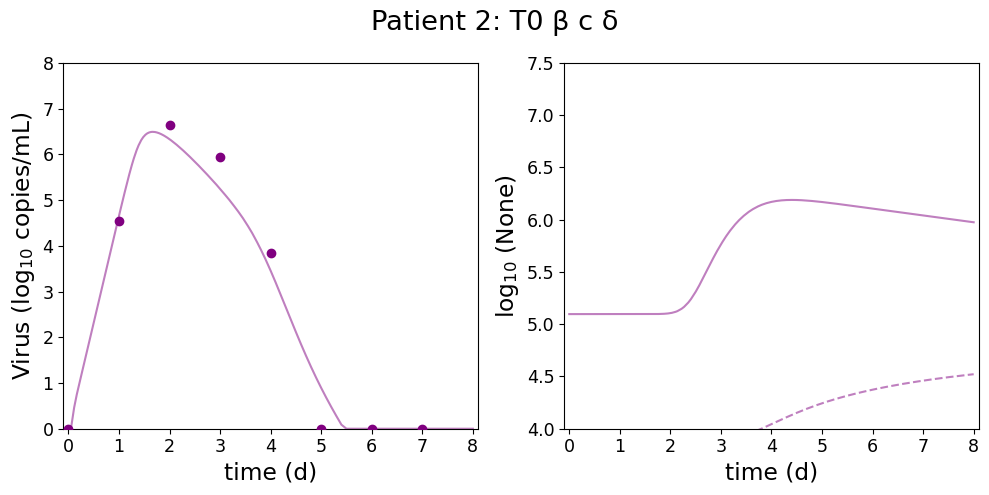

3 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 19.841404310555493
differential_evolution step 2: f(x)= 19.841404310555493
differential_evolution step 3: f(x)= 19.841404310555493
differential_evolution step 4: f(x)= 19.841404310555493
differential_evolution step 5: f(x)= 19.607266860055148
differential_evolution step 6: f(x)= 19.365584382750292
differential_evolution step 7: f(x)= 19.24050156916382
differential_evolution step 8: f(x)= 19.21653194994944
differential_evolution step 9: f(x)= 19.14314589580262
differential_evolution step 10: f(x)= 19.14314589580262
differential_evolution step 11: f(x)= 19.14314589580262
differential_evolution step 12: f(x)= 19.121852284175258
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Parameter T0: 39793241.75479703
Parameter beta: 4.549647225642789e-05
Parameter c: 6.2757145144136945
Parameter delta: 1.8539551556392209


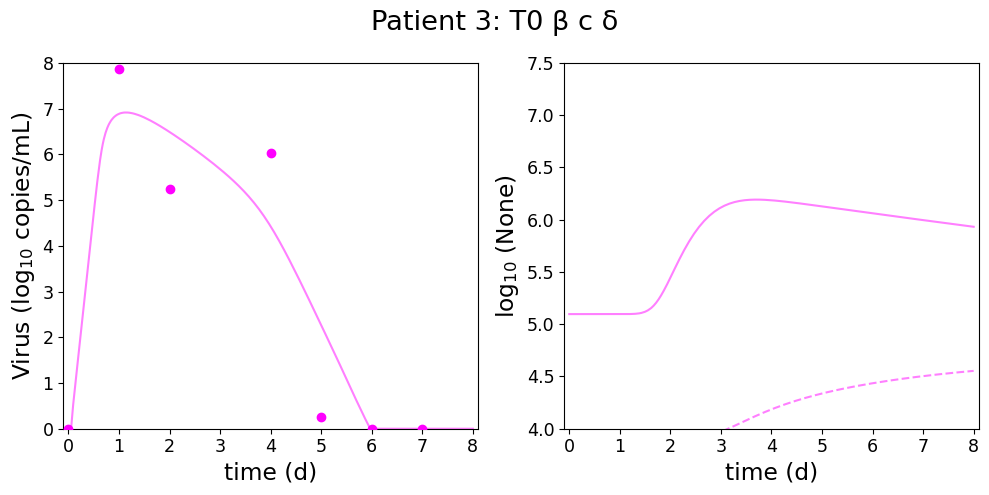

4 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 21.52957725409629
differential_evolution step 2: f(x)= 21.46570198705366
differential_evolution step 3: f(x)= 21.43809274818568
differential_evolution step 4: f(x)= 21.43809274818568
differential_evolution step 5: f(x)= 21.43809274818568
differential_evolution step 6: f(x)= 21.42614756283034
differential_evolution step 7: f(x)= 21.42614756283034
differential_evolution step 8: f(x)= 21.41991347667053
differential_evolution step 9: f(x)= 21.38474621659093
differential_evolution step 10: f(x)= 21.38474621659093
differential_evolution step 11: f(x)= 21.38474621659093
differential_evolution step 12: f(x)= 21.38474621659093
differential_evolution step 13: f(x)= 21.382371518718788
differential_evolution step 14: f(x)= 21.37824041135379
differential_evolution step 15: f(x)= 21.375787649271818
differential_evolution step 16: f(x)= 21.37355462173609
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0

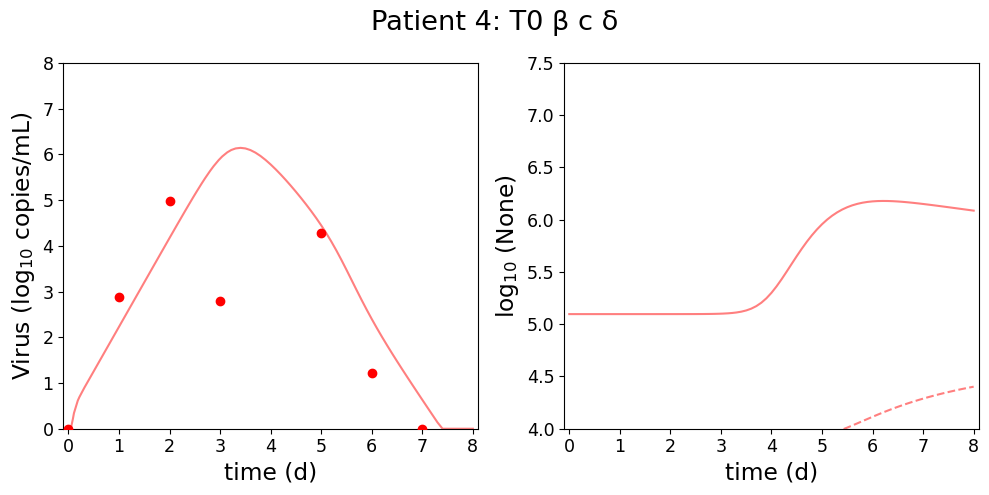

5 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.7226243690370002
differential_evolution step 2: f(x)= 2.644671991356098
differential_evolution step 3: f(x)= 2.385583301656599
differential_evolution step 4: f(x)= 2.385583301656599
differential_evolution step 5: f(x)= 2.3461706844578547
differential_evolution step 6: f(x)= 2.3461706844578547
differential_evolution step 7: f(x)= 2.2373925035280378
differential_evolution step 8: f(x)= 2.236440899551192
differential_evolution step 9: f(x)= 2.2236250336767904
differential_evolution step 10: f(x)= 2.195034391843443
differential_evolution step 11: f(x)= 2.195034391843443
differential_evolution step 12: f(x)= 2.195034391843443
differential_evolution step 13: f(x)= 2.195034391843443
differential_evolution step 14: f(x)= 2.193565665267086
differential_evolution step 15: f(x)= 2.1929385835274857
differential_evolution step 16: f(x)= 2.1913584481081214
differential_evolution step 17: f(x)= 2.1904892782102996
dif

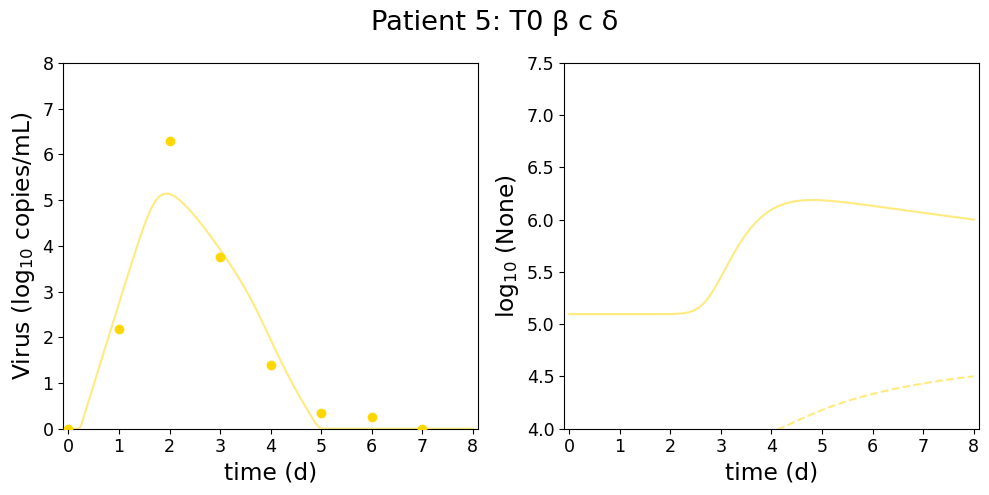

6 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.0214716005547853
differential_evolution step 2: f(x)= 0.9862365771049327
differential_evolution step 3: f(x)= 0.9030803206603657
differential_evolution step 4: f(x)= 0.9008004156211913
differential_evolution step 5: f(x)= 0.9005381989538643
differential_evolution step 6: f(x)= 0.8985326055196032
differential_evolution step 7: f(x)= 0.8961052066659188
differential_evolution step 8: f(x)= 0.8953211636439882
differential_evolution step 9: f(x)= 0.8953211636439882
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Parameter T0: 14124500.774979826
Parameter beta: 3.626451797648926e-05
Parameter c: 47.9832536223353
Parameter delta: 2.416255633031786


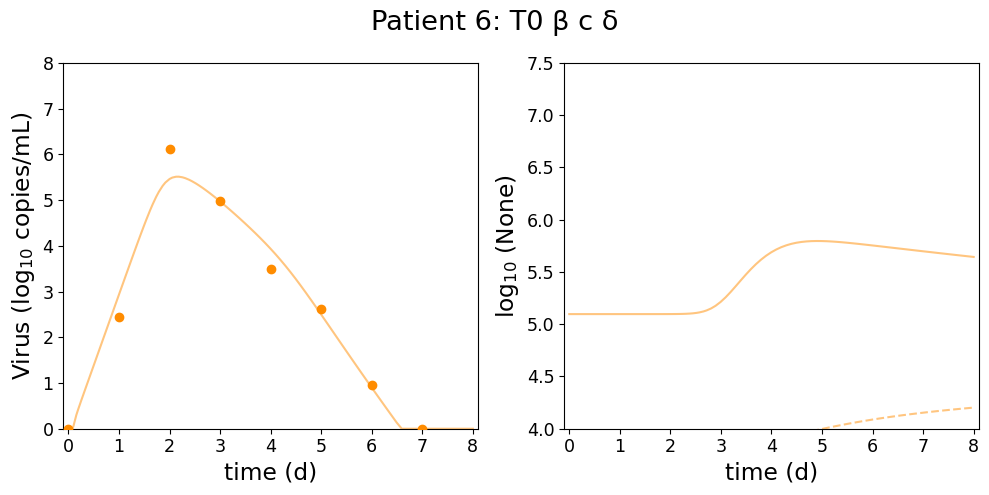

7 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 7.302203809446111
differential_evolution step 2: f(x)= 7.096748157934663
differential_evolution step 3: f(x)= 7.096748157934663
differential_evolution step 4: f(x)= 6.8884777788250755
differential_evolution step 5: f(x)= 6.8884777788250755
differential_evolution step 6: f(x)= 6.8884777788250755
differential_evolution step 7: f(x)= 6.8884777788250755
differential_evolution step 8: f(x)= 6.8884777788250755
differential_evolution step 9: f(x)= 6.8884777788250755
differential_evolution step 10: f(x)= 6.884344803703123
differential_evolution step 11: f(x)= 6.880680655081379
differential_evolution step 12: f(x)= 6.88067087351467
differential_evolution step 13: f(x)= 6.88067087351467
differential_evolution step 14: f(x)= 6.8800279328571685
differential_evolution step 15: f(x)= 6.8800279328571685
differential_evolution step 16: f(x)= 6.8800279328571685
differential_evolution step 17: f(x)= 6.8799258043795355
Pol

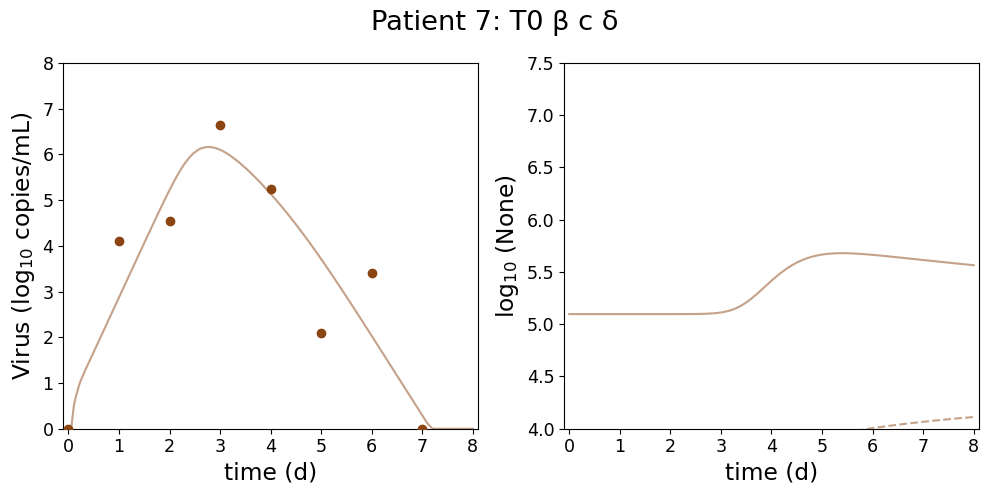

8 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 4.279402444221198
differential_evolution step 2: f(x)= 4.279402444221198
differential_evolution step 3: f(x)= 4.1984774687779876
differential_evolution step 4: f(x)= 4.19635935426653
differential_evolution step 5: f(x)= 4.0500982152309195
differential_evolution step 6: f(x)= 4.0500982152309195
differential_evolution step 7: f(x)= 4.030194483150996
differential_evolution step 8: f(x)= 4.02489131535773
differential_evolution step 9: f(x)= 4.0222380429801
differential_evolution step 10: f(x)= 4.0222380429801
differential_evolution step 11: f(x)= 4.0222380429801
differential_evolution step 12: f(x)= 4.0222380429801
differential_evolution step 13: f(x)= 4.021333798549187
differential_evolution step 14: f(x)= 4.021333798549187
differential_evolution step 15: f(x)= 4.021145556859145
differential_evolution step 16: f(x)= 4.021097984453919
Polishing solution with 'L-BFGS-B'
Results saved to sql/Canini_T0.db.
Para

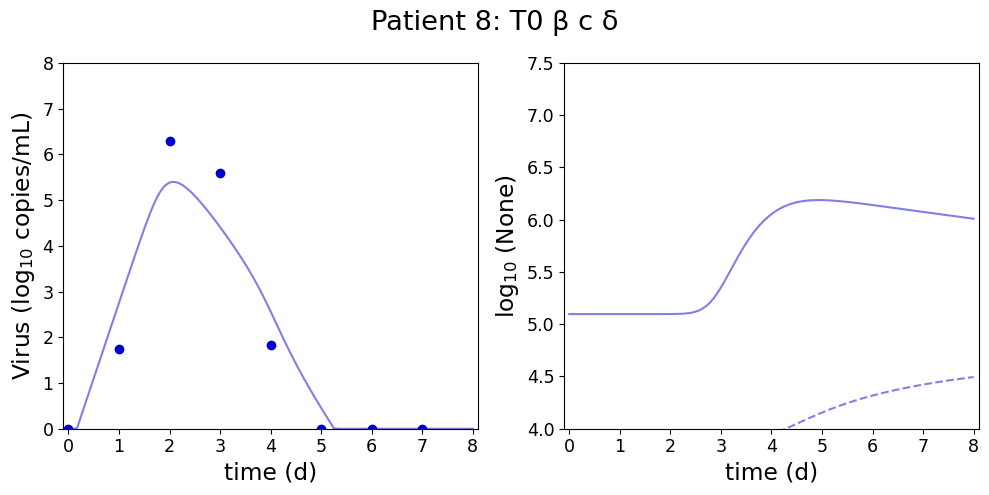

9 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 0.13812997693468806
differential_evolution step 2: f(x)= 0.09906785046056507
differential_evolution step 3: f(x)= 0.04692503063495945
differential_evolution step 4: f(x)= 0.04479541317122792
differential_evolution step 5: f(x)= 0.03589209878278247
differential_evolution step 6: f(x)= 0.03589209878278247
differential_evolution step 7: f(x)= 0.03589209878278247
differential_evolution step 8: f(x)= 0.03329023484895076
differential_evolution step 9: f(x)= 0.03329023484895076
differential_evolution step 10: f(x)= 0.029717101099588288
differential_evolution step 11: f(x)= 0.029717101099588288
differential_evolution step 12: f(x)= 0.029717101099588288
differential_evolution step 13: f(x)= 0.029717101099588288
differential_evolution step 14: f(x)= 0.029717101099588288
differential_evolution step 15: f(x)= 0.029717101099588288
differential_evolution step 16: f(x)= 0.02970151318957402
differential_evolution step 1

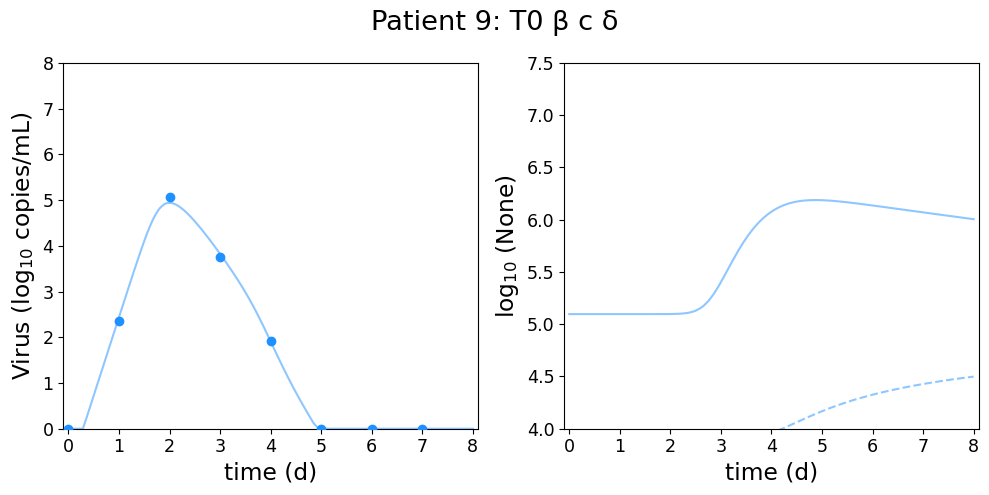

10 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 9.247028453775368
differential_evolution step 2: f(x)= 9.247028453775368
differential_evolution step 3: f(x)= 9.098247410688627
differential_evolution step 4: f(x)= 9.098247410688627
differential_evolution step 5: f(x)= 9.098247410688627
differential_evolution step 6: f(x)= 9.058869356052178
differential_evolution step 7: f(x)= 9.058869356052178
differential_evolution step 8: f(x)= 9.046501618118366
differential_evolution step 9: f(x)= 9.046501618118366
differential_evolution step 10: f(x)= 9.046501618118366
differential_evolution step 11: f(x)= 9.046501618118366
differential_evolution step 12: f(x)= 9.041080807997764
differential_evolution step 13: f(x)= 9.041080807997764
differential_evolution step 14: f(x)= 9.041080807997764
differential_evolution step 15: f(x)= 9.040727652065913
differential_evolution step 16: f(x)= 9.036647017638842
differential_evolution step 17: f(x)= 9.036647017638842
differenti

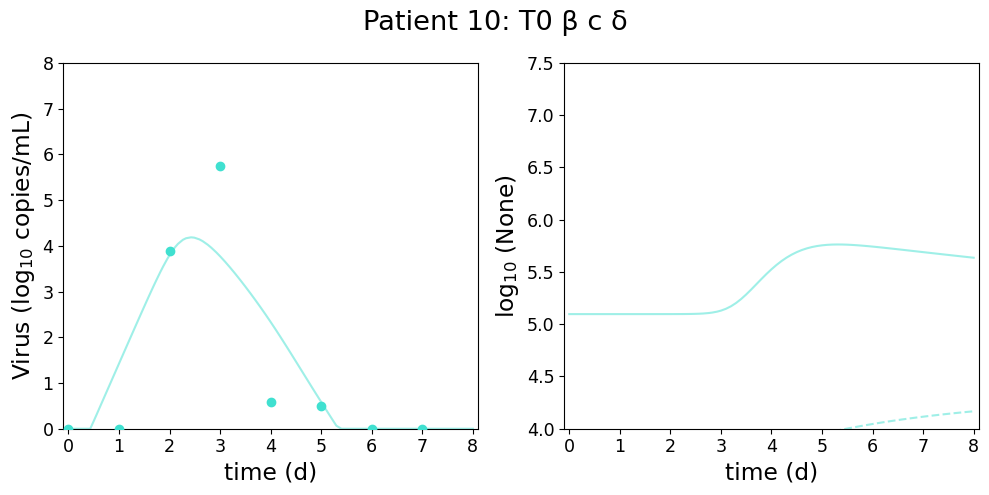

11 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 6.152839138690368
differential_evolution step 2: f(x)= 5.414158727806969
differential_evolution step 3: f(x)= 5.414158727806969
differential_evolution step 4: f(x)= 5.414158727806969
differential_evolution step 5: f(x)= 5.314398406114618
differential_evolution step 6: f(x)= 5.314398406114618
differential_evolution step 7: f(x)= 5.314398406114618
differential_evolution step 8: f(x)= 5.230183055671258
differential_evolution step 9: f(x)= 5.230183055671258
differential_evolution step 10: f(x)= 5.230183055671258
differential_evolution step 11: f(x)= 5.214734407312263
differential_evolution step 12: f(x)= 5.213151490131672
differential_evolution step 13: f(x)= 5.213151490131672
differential_evolution step 14: f(x)= 5.213151490131672
differential_evolution step 15: f(x)= 5.213151490131672
differential_evolution step 16: f(x)= 5.212998324705106
differential_evolution step 17: f(x)= 5.211797570678934
differenti

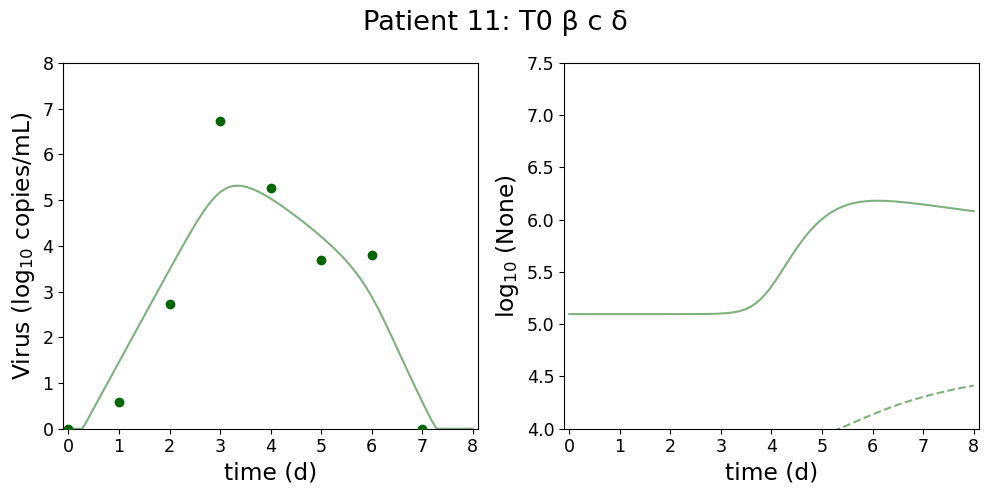

12 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 0.28155676915541383
differential_evolution step 2: f(x)= 0.2809974457181203
differential_evolution step 3: f(x)= 0.2396604741918561
differential_evolution step 4: f(x)= 0.21549097317945234
differential_evolution step 5: f(x)= 0.21549097317945234
differential_evolution step 6: f(x)= 0.2099529015117966
differential_evolution step 7: f(x)= 0.20853657223119695
differential_evolution step 8: f(x)= 0.20853657223119695
differential_evolution step 9: f(x)= 0.20853657223119695
differential_evolution step 10: f(x)= 0.20591474603901613
differential_evolution step 11: f(x)= 0.20445792975209406
differential_evolution step 12: f(x)= 0.20283894022771656
differential_evolution step 13: f(x)= 0.2025812282789371
differential_evolution step 14: f(x)= 0.2025812282789371
differential_evolution step 15: f(x)= 0.2025812282789371
differential_evolution step 16: f(x)= 0.2025812282789371
differential_evolution step 17: f(x)= 0.2

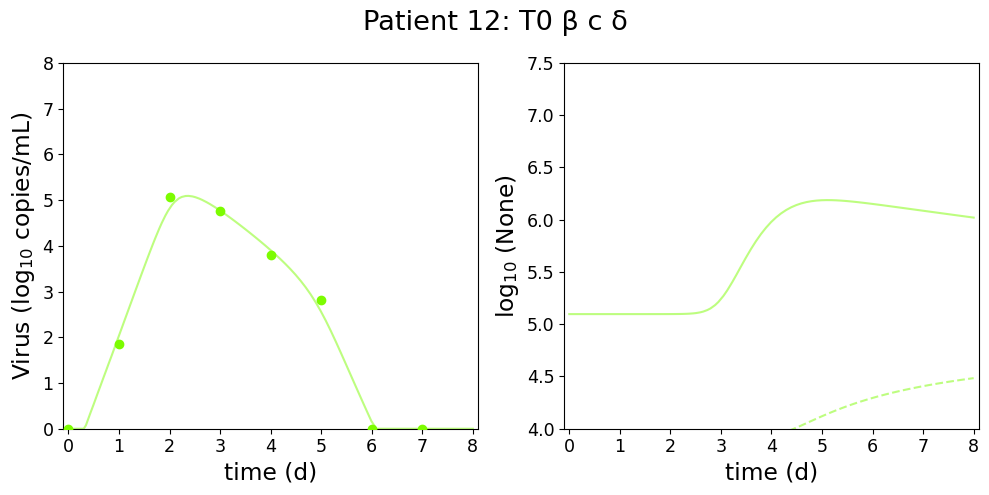

In [3]:
# Canini T0
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': None, 'sol_key': [4, 5], 'ylims': [4,7.5]}, 
]

n_Z = 13
df = pd.read_excel("../Data/Canini.xlsx")
df_Canini = df[['VOLUNTEER', 'DAY', 'V', 'RS', 'SS', 'TSS']]

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=1.25E5, l_lim=2.1E4, u_lim=1.7E5, method='fixed', space='log10'),
    M0=Parameter(name='M0', val=7497, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=4E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=4.9E-05, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=2.837, l_lim=0.05, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=141, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=1.333, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=0.18, l_lim=0.05, u_lim=10, method='fixed', space='log10'), 
    a=Parameter(name='a', val=7.43, l_lim=1.0, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.17, l_lim=0.05, u_lim=2, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=.27, l_lim=0.05, u_lim=10, method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=100000, l_lim=1E2, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.00469, l_lim=5E-4, u_lim=1E-1, method='fixed', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=0.266, l_lim=0.25, u_lim=2, method='fixed', space='normal'),
)

t_span = (0, 8)

shedders = list(range(1,13))
#shedders = list(range(13,25))
#shedders = list(range(25,37))
#shedders = list(range(37,45))
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

patients = Patients(ids=ids, df=df_Canini, t_span=t_span, parameters=parameters, states=states)
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Canini_T0')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

In [ ]:
# Individual Fits ASA

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='normal'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E4, u_lim=3E5, method='file', space='normal'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='normal'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='normal'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='normal'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-2, method='fit', space='normal'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='normal'), 
    p=Parameter(name='p', val=4.184819, l_lim=0.1, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=1.0, u_lim=100, method='fit', space='normal'), 
    delta=Parameter(name='delta', val=3, l_lim=0.1, u_lim=10, method='fit', space='normal'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.1, u_lim=10, method='fit', space='normal'), 
    a=Parameter(name='a', val=5, l_lim=0.1, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='normal'),
    zeta=Parameter(name='zeta', val=0.7, l_lim=0.01, u_lim=1, method='fit', space='normal'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='normal'), #2.7 for TEMs
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='normal'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.5, u_lim=3, method='fit', space='normal'),
)

t_span = (0, 8)
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in [103]:
    for i in range(10):
        results = patients.optimize_parameters(method='ASA', opt_target=target, 
                                            iter=10000, verbose=True, path='Draft_ASA')

        plot(results, subplot_configuration, t_span, figsize=(10,5))